In [41]:
import os
import sys
import urllib, io
import pickle

import random
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import euclidean_distances, jaccard_score, pairwise_distances

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64
import requests

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils
import domino_settings as dominoes
import domino_settings_monochrome as mono_dominoes

import importlib


In [42]:
experiment_name = 'build_components'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [43]:
# plot setup
plt.rcParams["figure.figsize"] = (6,4)

In [44]:
# which iteration name should we use?
# iteration_name = 'build_components_build_recall_prolific_pilot_12_towers'
iteration_name = 'build_components_build_recall_prolific_pilot_6_towers_2_rep'

### Load csvs from dataframe generator

In [45]:
df_learn = pd.read_csv(experiment_results_dir + '/df_learn_{}.csv'.format(iteration_name))
df_trial = pd.read_csv(experiment_results_dir + '/df_trial_{}.csv'.format(iteration_name))
df_recall_trial = pd.read_csv(experiment_results_dir + '/df_recall_trial_{}.csv'.format(iteration_name))
df_recalled_towers = pd.read_csv(experiment_results_dir + '/df_recalled_towers_{}.csv'.format(iteration_name))
df_blocks = pd.read_csv(experiment_results_dir + '/df_blocks_{}.csv'.format(iteration_name))

In [46]:
df_recalled_towers = df_recalled_towers.sort_values('trial_start_time')

## Add useful columns

In [47]:
### Utils

def get_block_map(blocks):
    return utils.worldify(ast.literal_eval(blocks)).block_map[2:,0:4]

def mean_tower(group):
    return np.mean(group['square_map'])

### stimulus info

In [48]:
# import stim dataframes
df_towers = pd.read_csv('../../stimuli/block_utils/ambiguous/ambiguous_composite_towers.csv')

In [49]:
df_towers['tower_id'] = df_towers.tower_id_tall

In [50]:
df_learn = df_learn.merge(df_towers[['tower_id','stim_wide']], how='left', on = 'tower_id')
df_learn['square_map'] = df_learn['stim_wide'].apply(lambda x: get_block_map(x))

In [51]:
df_learn.rep.value_counts()

rep
1.0    300
2.0    300
Name: count, dtype: int64

In [52]:
df_learn_rep_1 = df_learn[df_learn.rep==1]

### Timing data

In [53]:
# df_build['trial_num'] = df_build.trial_index - 3
# df_build['trial_num']

# build_start = df_build[df_build.trial_num == 0][['gameID','trial_start_time']]
# build_start = build_start.rename(columns = {'trial_start_time': 'build_start_time'})

# build_finish = df_build[df_build.trial_num == 15][['gameID','timeAbsolute']]
# build_finish = build_finish.rename(columns= {'timeAbsolute':'build_finish_time'})
# build_timing = build_start.merge(build_finish, on='gameID')
# build_timing['build_duration'] = build_timing['build_finish_time'] - build_timing['build_start_time']
# build_timing['build_duration_min'] = build_timing['build_duration'] / (1000 * 60)
# build_timing

#### export for stats

# Analysis 

### Analysis setup

In [54]:
# setup

monochrome = True
block_settings = mono_dominoes if monochrome else dominoes
importlib.reload(block_settings)

block_dims = block_settings.block_dims
block_colors = block_settings.block_colors
world_width = block_settings.world_width
world_height = block_settings.world_height
world_center = block_settings.world_center
black = ['#000000','#000000'] # used to display silhouettes
grey = ['#333333','#333333']

### plot setup

In [126]:
# sns.set_context('poster')
# sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})
import poster_plot_settings
from poster_plot_settings import palette

## Building analyses

### Tower rendering

In [56]:
importlib.reload(utils)

<module 'blockworld_utils' from '/Users/will/bc_perception/analysis/build_components/../../stimuli/block_utils/blockworld_utils.py'>

#### Display target towers

In [57]:
def show_tower(url, ax):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
#     plt.figure(figsize=(2,1))
    ax.imshow(img)
    ax.axis('off')
    
def show_tower_subplot(tower_id,
                      ax,
              url_stem = "https://zipping-composites-monochrome-png-rerender.s3.amazonaws.com/tower_4_block_unique_silhouettes_composites_monochrome_png_rerender_{}.png"):
    
    response = requests.get(url_stem.format(tower_id))
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(tower_id)

In [58]:
tower_ids = df_learn.tower_id.unique()

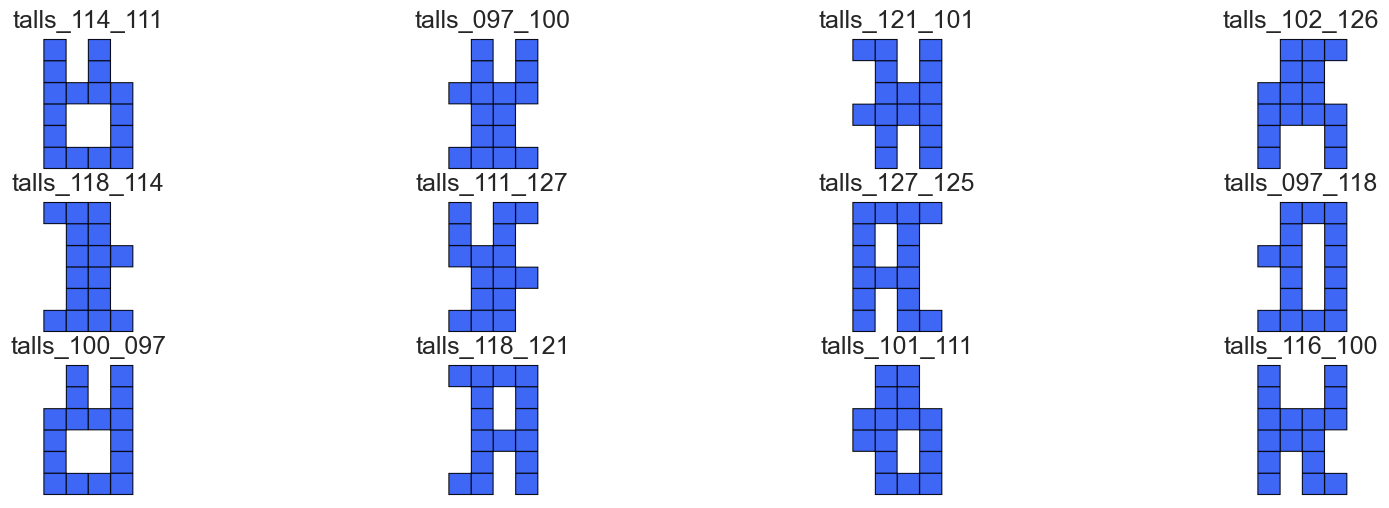

In [59]:
n_row = 3
fig, axs = plt.subplots(n_row, int(len(tower_ids)/n_row), figsize=(20,6))

for i, tower in enumerate(tower_ids):
    show_tower_subplot(tower, axs[int(np.floor(i/(len(tower_ids)/n_row))), i%(int(len(tower_ids)/n_row))])

In [60]:
# _ = [utils.render_zipping_stim_squares(
#     utils.worldify(ast.literal_eval(tower)['blocks']).block_map,
#     color=block_colors[0]) \
#     for tower in df_learn.stimulus.unique()]

#### Display recalled towers

In [61]:
df_recalled_towers['tower_details'] = df_recalled_towers.towerDetails.apply(ast.literal_eval)
df_recalled_towers['alignedTowerBlocks'] = df_recalled_towers.alignedTowerBlocks.apply(ast.literal_eval)
df_learn['stimulus'] = df_learn.stimulus.apply(ast.literal_eval)

In [62]:
def render_tower(tower_blocks):
    world = utils.worldify(tower_blocks, 
                       world_width = 10,
                       world_height = 12)
    block_map = world.block_map
    fig = utils.render_tower_squares(block_map,
                               scaling_factor = 20,
                               line_width=1,
                               color=block_colors[0])
    return fig
    
def show_recalled_towers(df):
    
    recall_worlds = df['alignedTowerBlocks'].apply(lambda x: utils.worldify(x, 
                                                                       world_width = 10,
                                                                       world_height = 12))
    
    n_towers = len(recall_worlds)
    print(df.iloc[0]['gameID'])
    
    figsize = (12,1.4)
    
    fig, axs = plt.subplots(1, 6, figsize = figsize)
    
    for ax in axs.flatten():
        ax.axis('off')
    
    for i, world in enumerate(recall_worlds):
#         utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i])
        ax=axs[i]
        block_map = world.block_map
        utils.render_tower_squares(block_map,
                                   scaling_factor = 20,
                                   line_width=1,
                                   fig=fig,
                                   ax=ax,
                                   color=block_colors[0])
        
        
condition_colors = {
    'build': '#ffd818',
    'view': '#c7c6f6'
}
        
def show_target_towers(df):
    
#     df.sort_values('condition')
    
    target_worlds = df['stimulus'].apply(lambda x: utils.worldify(x['blocks'], 
                                                                       world_width = 10,
                                                                       world_height = 12)).iloc[6:]
    
    print(df.iloc[0]['gameID'])
    
    n_towers = len(target_worlds)
    
    figsize = (12,1.4)
    
    fig, axs = plt.subplots(1, 6, figsize = figsize)
    
    for ax in axs.flatten():
        ax.axis('off')
        
    for i, world in enumerate(target_worlds):
#         utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i])
        ax=axs[i]
        block_map = world.block_map
        condition = df.iloc[i]['condition']
        utils.render_tower_squares(block_map,
                                   scaling_factor = 20,
                                   line_width=1,
                                   fig=fig,
                                   ax=ax,
                                   color=condition_colors[condition])

0403-00b72085-5f9c-4337-bec4-04dd488251fa
0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9
0617-9ddb7997-5774-4c33-849a-ab70289df180
0821-da9c2fa8-8329-425d-8259-d2bac1ab398e
0837-7dc8f2c1-c6df-400c-ae2f-2174ffd0ffb1
0906-c7df6e7c-dbee-4ad8-9dc4-146e043ac321
1203-5578863b-0366-422e-96f5-82f16138217f
1510-718bfa55-e1e6-4fc6-884b-cf040464e4e4
1566-41c08046-61e8-4354-936f-97f488becf81
1708-3959e0a4-2a57-446e-af68-ed65c890f8c5
1995-78ea939b-e6f3-4652-8da9-a24a7f23aff6
2149-9f29790e-0346-41b9-923e-0fe3ab918514
2292-aca8604c-6823-4b21-9d62-05456ee994c9
2405-46fbdc52-eb7f-4311-8405-73ded41ceaf4
2465-1f63d92b-725b-4851-b910-9b71e1731fff
2770-7ced2d66-baab-4591-9de9-ed7b7e0ed202
2785-b96f9a3a-e610-4ed3-ac1f-3d3cfb64ec1d
2793-746fc5b9-f318-4963-82a4-3ec1818eb7fc
3038-fc68f5d1-26ad-4d4e-b667-b918239507e0
3078-670e6c52-abc7-4109-9187-44f49d80bdea
3186-cb5d08c6-5fd0-4e90-ab0d-7fa7ba7fb081
3491-e0489bd8-a877-48be-b7f8-a2a60fc0b29f
3493-b9f1d2a9-0a74-44bf-abf4-4d3e55e9f9cd
4207-a4d9145c-c5c1-42c6-9c1b-919ae

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_34165/3270252255.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 6, figsize = figsize)


4660-86548240-5c5b-41d9-85af-01b7d51604f3
4735-bf35f3c0-da3a-4bd4-9825-bf93e722a560
5069-f78bc975-b032-4690-9f05-2509e97c86a7
5151-23e4fba2-ee1a-4678-b0a0-ad658010c804
5192-2a415848-bcd3-436f-a63c-87cf198bddf4
5494-bb8b8dc6-841d-48dc-b262-f28c7a342bce
5533-012c1356-92a6-4a60-bd4e-8ff5a33aa8f6
5543-d4c4a54f-7a36-41e8-a48d-699dfa13007e
5955-c71bea47-b459-49a5-b5a9-69ce06110ee0
6806-1b0c1fdb-1f6a-435c-8953-e906215530ab
7004-4417afd1-9081-42a3-b653-9cf279904cb5
7016-f8c8cb80-05a6-4703-aaf0-c19d4bd76be1
7246-1de59a77-8cc2-4cc4-b787-296bac25fd9e
7596-b4b1af8a-ae20-4a8e-a9c8-399036693648
7773-1b67ae19-c0ba-4173-916f-6905b72c894c
8269-6b7d581c-d5ac-4d0d-a48d-db6da4e40ccf
8430-1b1d568f-f51e-44e7-bb75-f7629d3a44ed
8606-acc7425f-fe32-4cec-a98b-d094e900142e
8685-2b9de59d-e1a1-44b2-9ab0-63ae52599be7
9009-d9ea75a9-7210-4d13-b88b-45f9ce36b9be
9090-04f7813f-1c10-43ae-846b-97da741f5acc
9122-98410562-bea6-46af-8e2b-e03cd2cea96b
9233-2420fc0d-679a-4a08-8e59-577c9a0aaf55
9343-013fb2db-94d6-4c42-b102-167d8

""


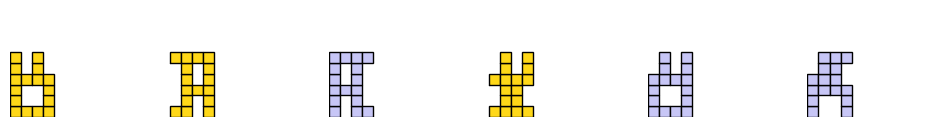

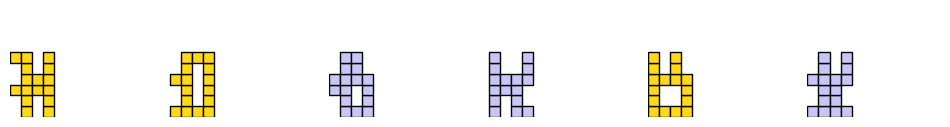

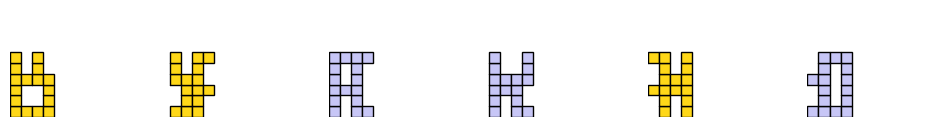

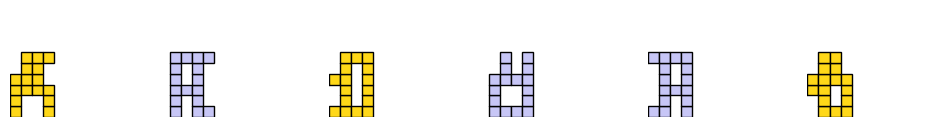

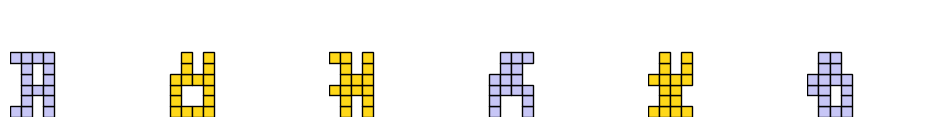

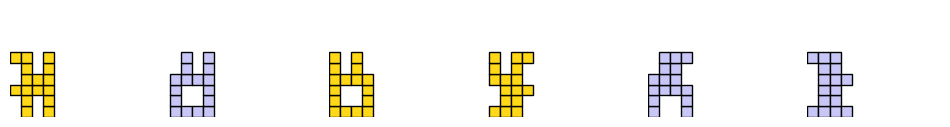

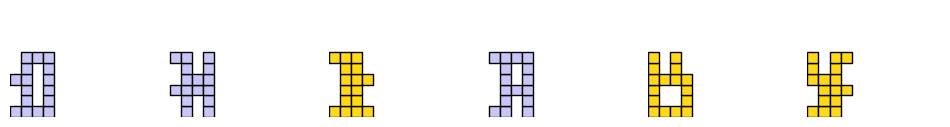

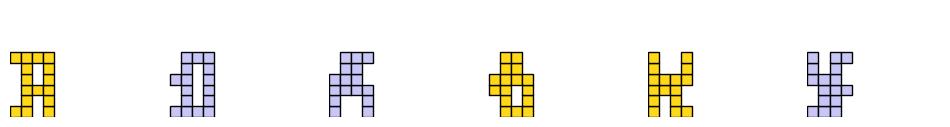

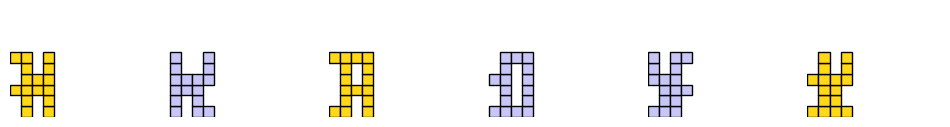

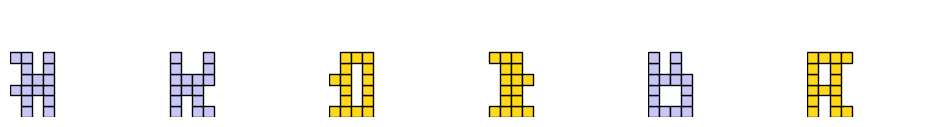

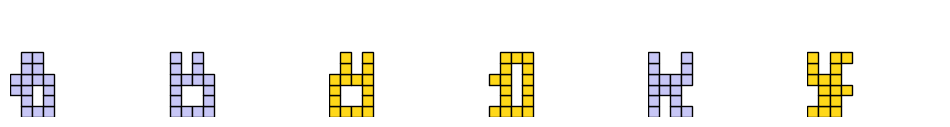

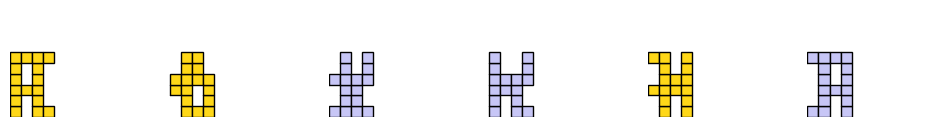

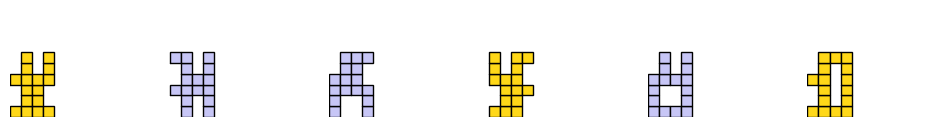

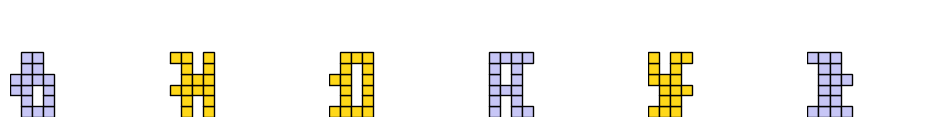

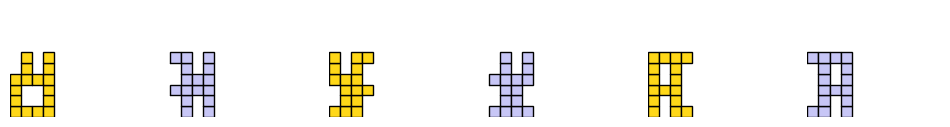

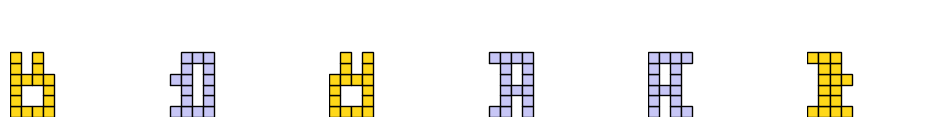

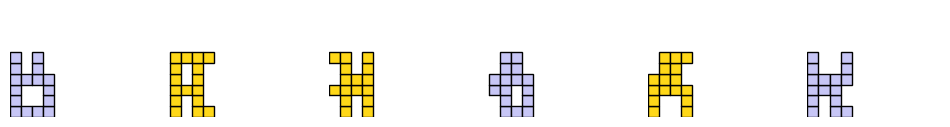

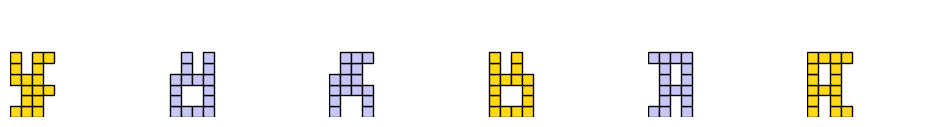

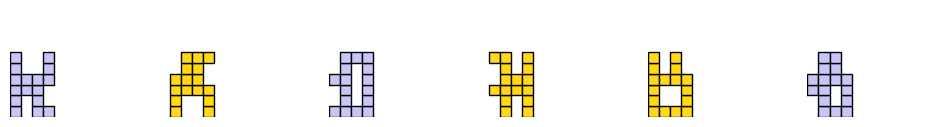

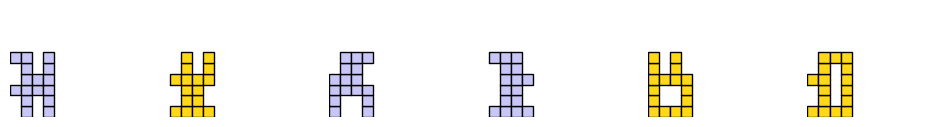

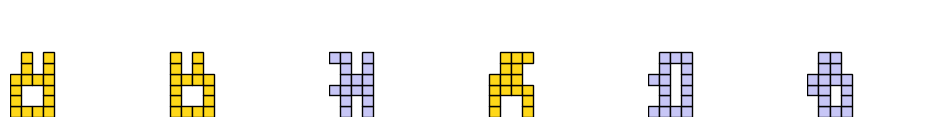

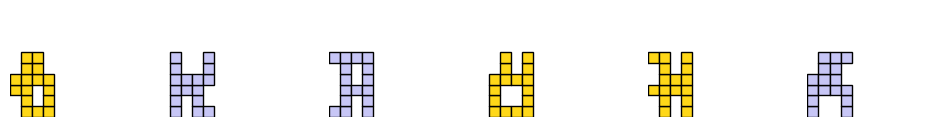

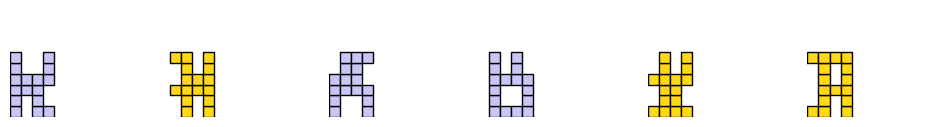

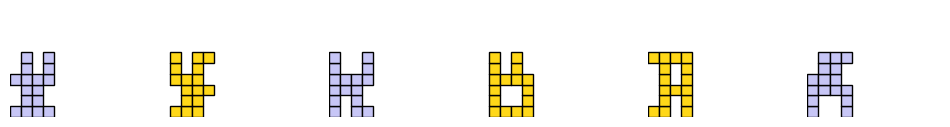

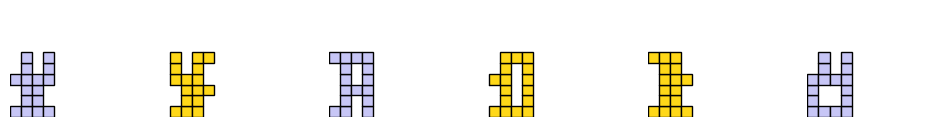

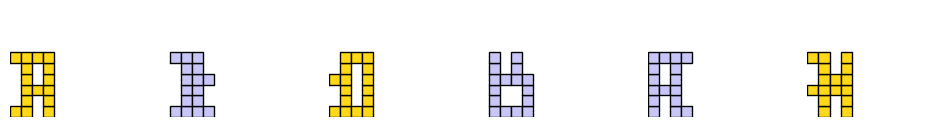

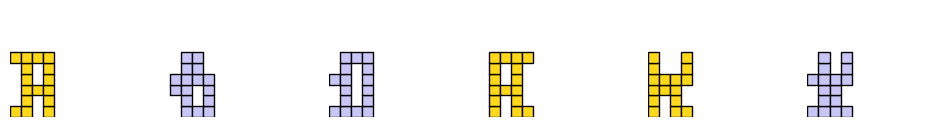

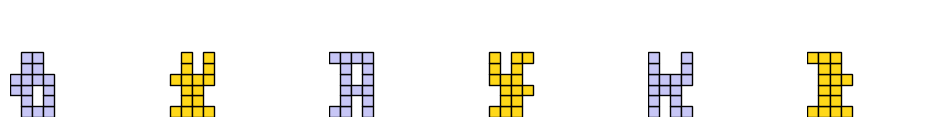

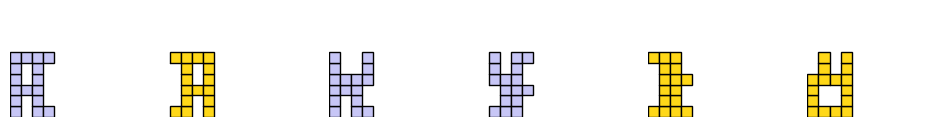

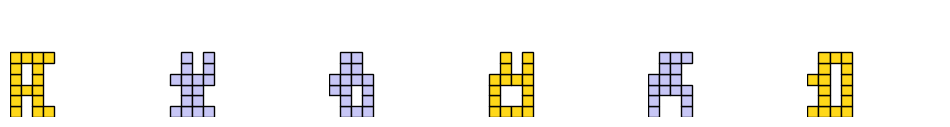

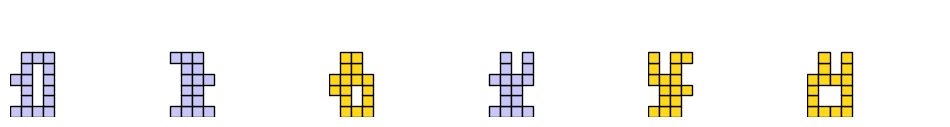

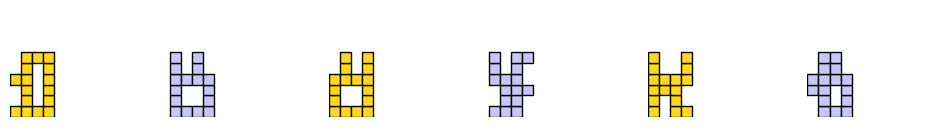

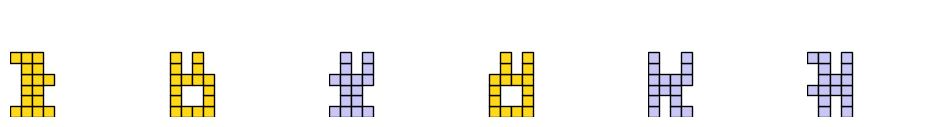

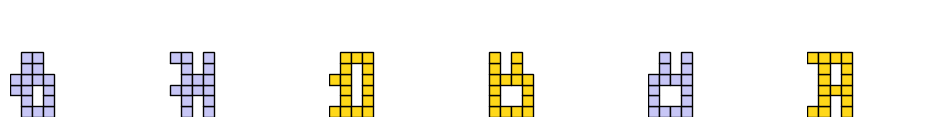

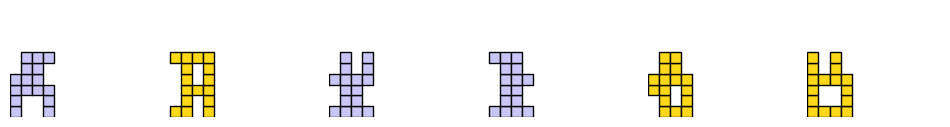

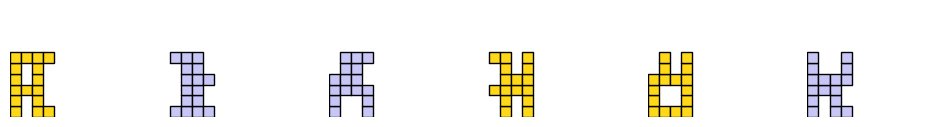

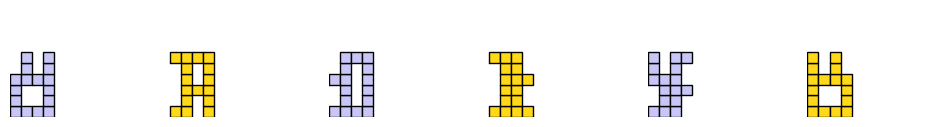

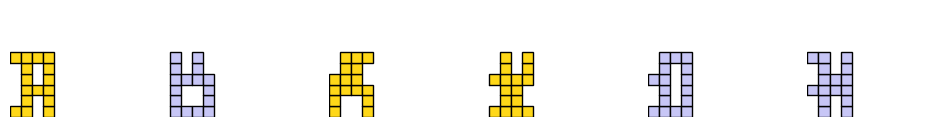

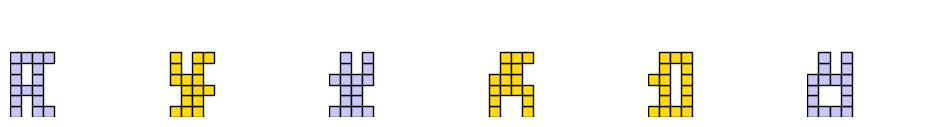

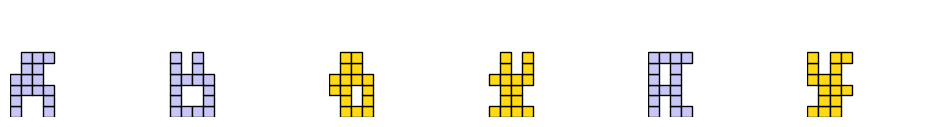

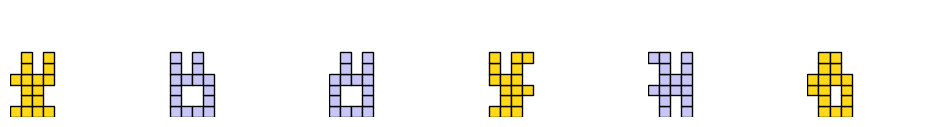

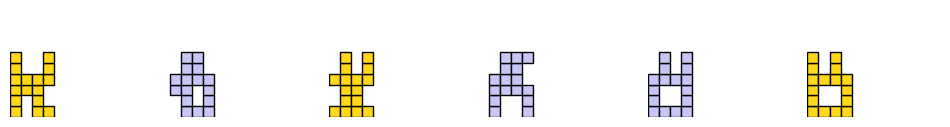

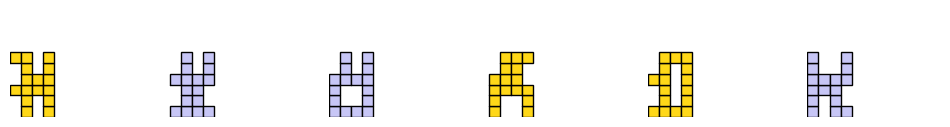

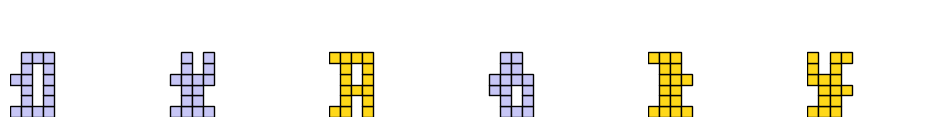

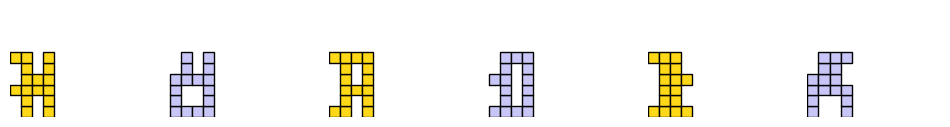

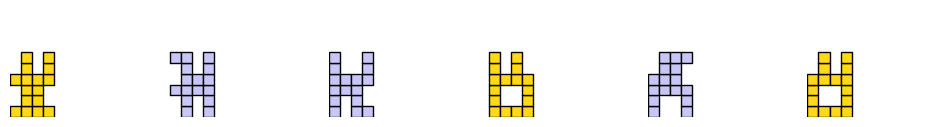

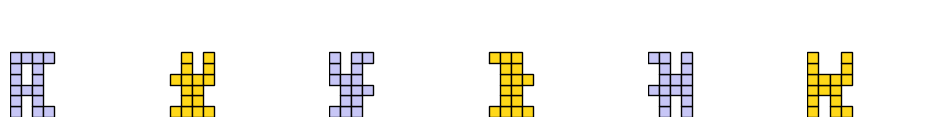

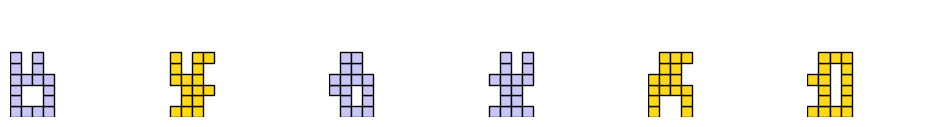

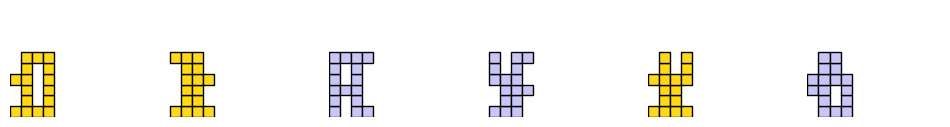

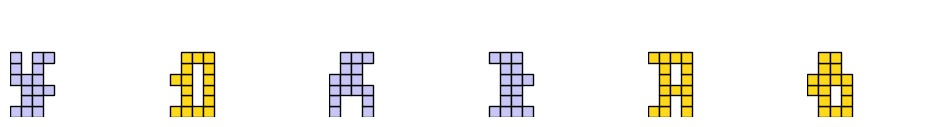

In [63]:
# display encode trials
df_learn.sort_values(['gameID','trial_start_time']).groupby('gameID').apply(show_target_towers)

In [64]:
# render one
# render_tower(df_recalled_towers['tower_details'][1]['blocks'])

In [65]:
# # render all
# _ = [render_tower(tower['blocks']) for tower in df_recalled_towers['tower_details']]

0403-00b72085-5f9c-4337-bec4-04dd488251fa
0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9
0617-9ddb7997-5774-4c33-849a-ab70289df180
0821-da9c2fa8-8329-425d-8259-d2bac1ab398e
0837-7dc8f2c1-c6df-400c-ae2f-2174ffd0ffb1
0906-c7df6e7c-dbee-4ad8-9dc4-146e043ac321
1203-5578863b-0366-422e-96f5-82f16138217f
1510-718bfa55-e1e6-4fc6-884b-cf040464e4e4
1566-41c08046-61e8-4354-936f-97f488becf81
1708-3959e0a4-2a57-446e-af68-ed65c890f8c5
1995-78ea939b-e6f3-4652-8da9-a24a7f23aff6
2149-9f29790e-0346-41b9-923e-0fe3ab918514
2292-aca8604c-6823-4b21-9d62-05456ee994c9
2405-46fbdc52-eb7f-4311-8405-73ded41ceaf4
2465-1f63d92b-725b-4851-b910-9b71e1731fff
2770-7ced2d66-baab-4591-9de9-ed7b7e0ed202
2785-b96f9a3a-e610-4ed3-ac1f-3d3cfb64ec1d
2793-746fc5b9-f318-4963-82a4-3ec1818eb7fc
3038-fc68f5d1-26ad-4d4e-b667-b918239507e0
3078-670e6c52-abc7-4109-9187-44f49d80bdea
3186-cb5d08c6-5fd0-4e90-ab0d-7fa7ba7fb081
3491-e0489bd8-a877-48be-b7f8-a2a60fc0b29f
3493-b9f1d2a9-0a74-44bf-abf4-4d3e55e9f9cd
4207-a4d9145c-c5c1-42c6-9c1b-919ae

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_34165/3270252255.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 6, figsize = figsize)


4735-bf35f3c0-da3a-4bd4-9825-bf93e722a560
5069-f78bc975-b032-4690-9f05-2509e97c86a7
5151-23e4fba2-ee1a-4678-b0a0-ad658010c804
5192-2a415848-bcd3-436f-a63c-87cf198bddf4
5494-bb8b8dc6-841d-48dc-b262-f28c7a342bce
5533-012c1356-92a6-4a60-bd4e-8ff5a33aa8f6
5543-d4c4a54f-7a36-41e8-a48d-699dfa13007e
5955-c71bea47-b459-49a5-b5a9-69ce06110ee0
6806-1b0c1fdb-1f6a-435c-8953-e906215530ab
7004-4417afd1-9081-42a3-b653-9cf279904cb5
7016-f8c8cb80-05a6-4703-aaf0-c19d4bd76be1
7246-1de59a77-8cc2-4cc4-b787-296bac25fd9e
7596-b4b1af8a-ae20-4a8e-a9c8-399036693648
7773-1b67ae19-c0ba-4173-916f-6905b72c894c
8269-6b7d581c-d5ac-4d0d-a48d-db6da4e40ccf
8430-1b1d568f-f51e-44e7-bb75-f7629d3a44ed
8606-acc7425f-fe32-4cec-a98b-d094e900142e
8685-2b9de59d-e1a1-44b2-9ab0-63ae52599be7
9009-d9ea75a9-7210-4d13-b88b-45f9ce36b9be
9090-04f7813f-1c10-43ae-846b-97da741f5acc
9122-98410562-bea6-46af-8e2b-e03cd2cea96b
9233-2420fc0d-679a-4a08-8e59-577c9a0aaf55
9343-013fb2db-94d6-4c42-b102-167d834d6e0b
9537-a4cb8e30-2593-4f24-a368-351cf

""


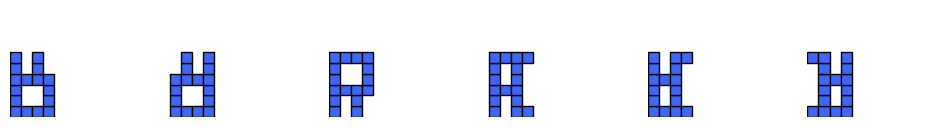

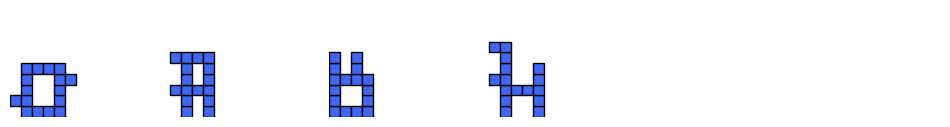

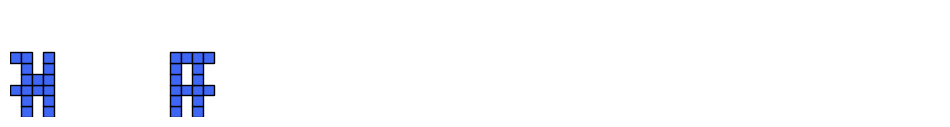

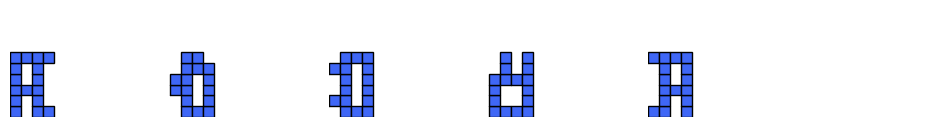

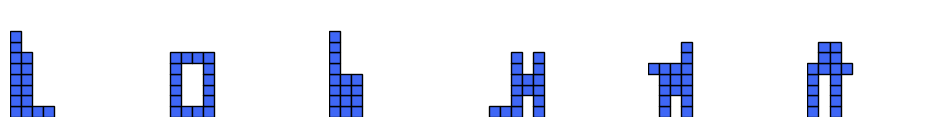

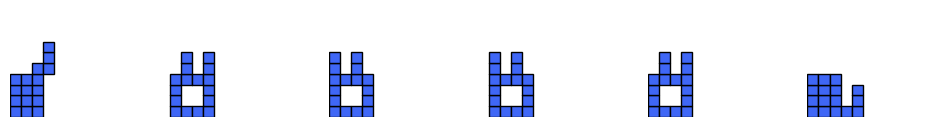

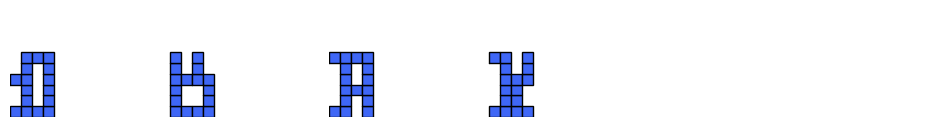

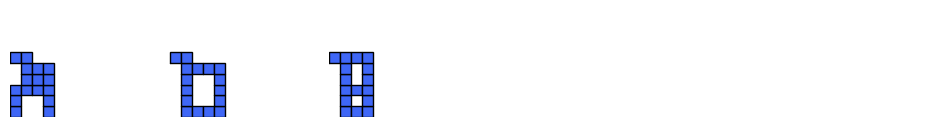

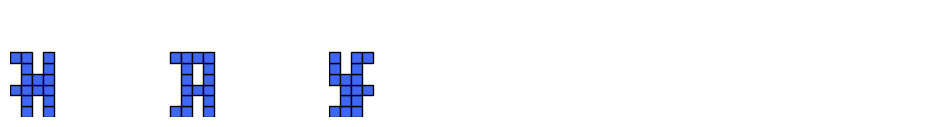

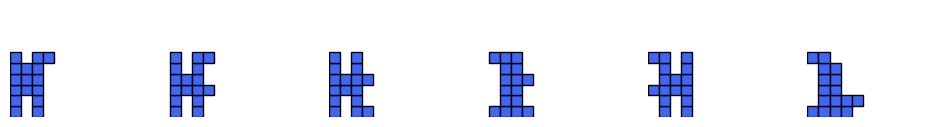

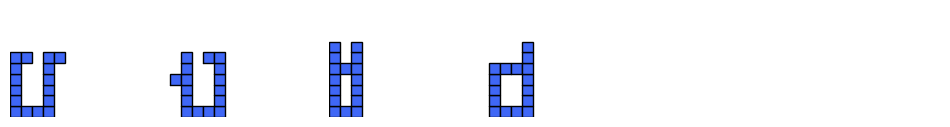

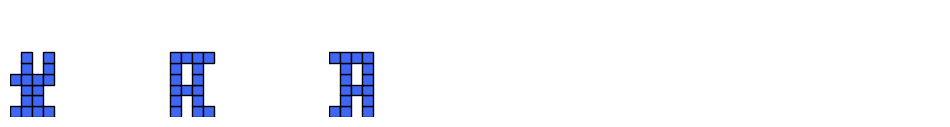

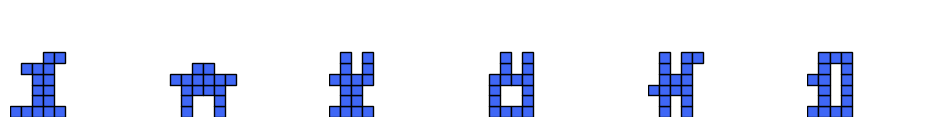

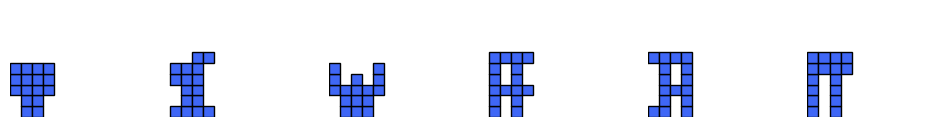

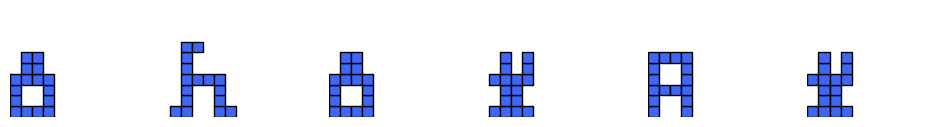

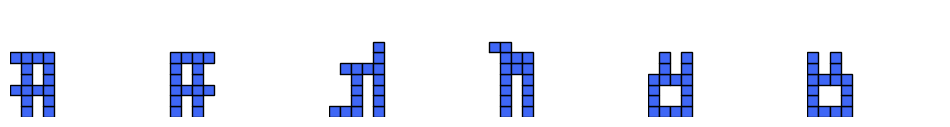

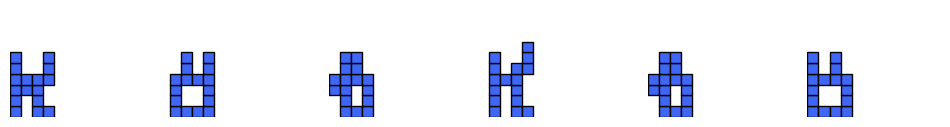

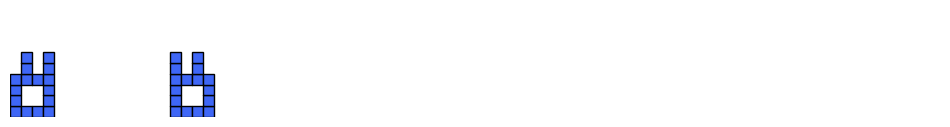

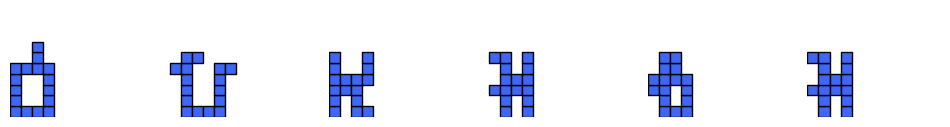

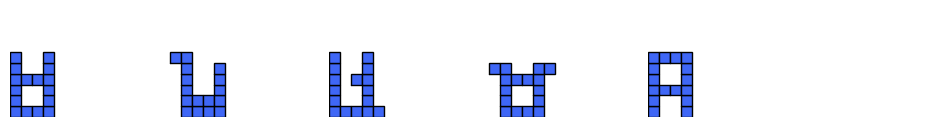

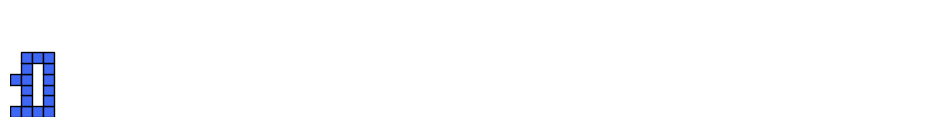

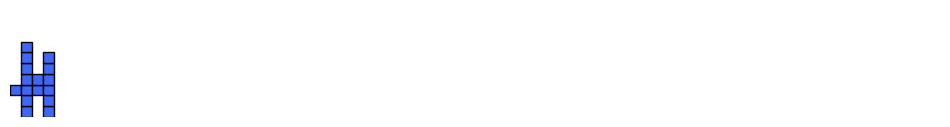

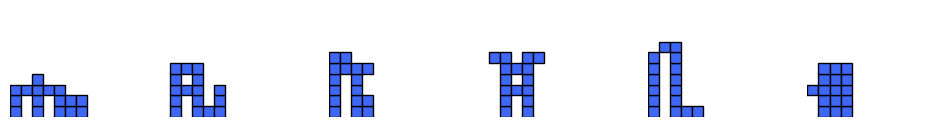

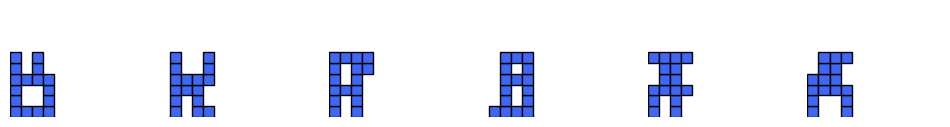

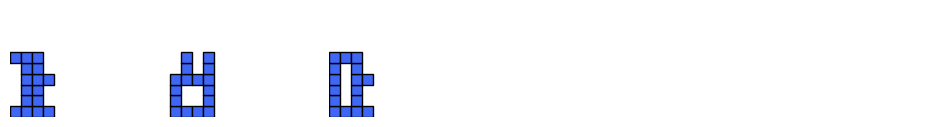

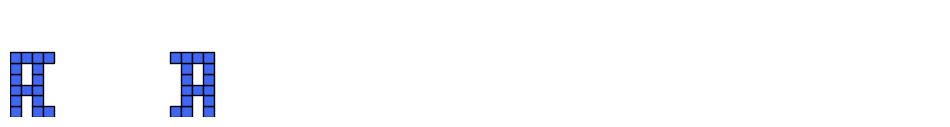

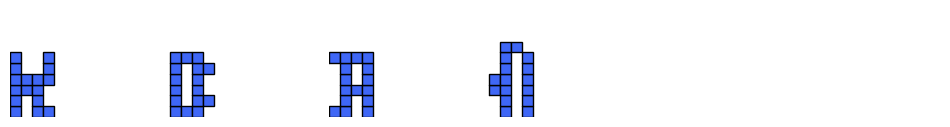

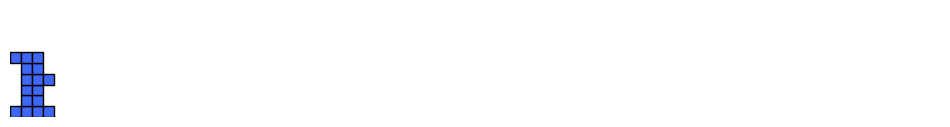

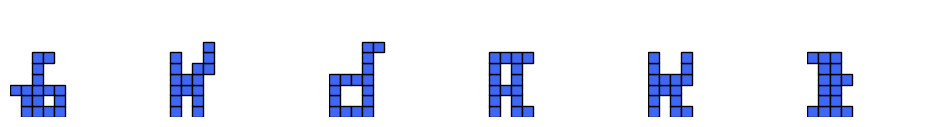

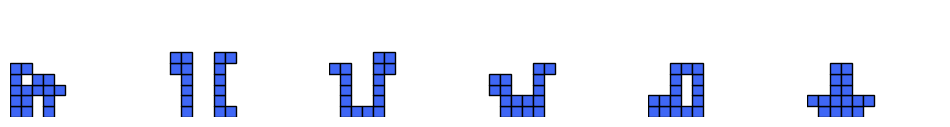

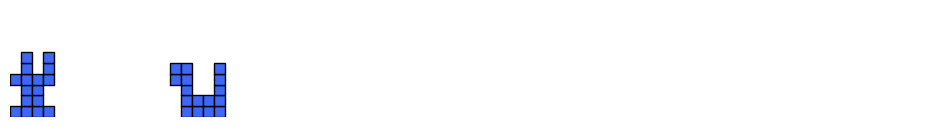

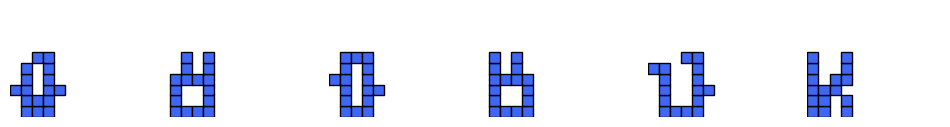

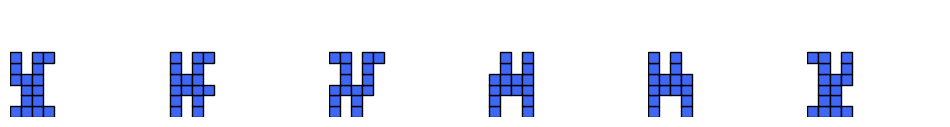

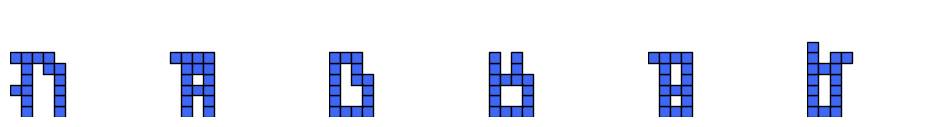

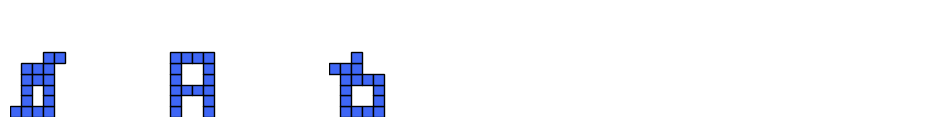

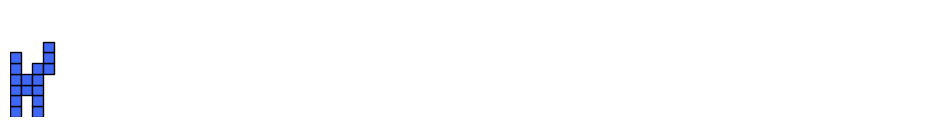

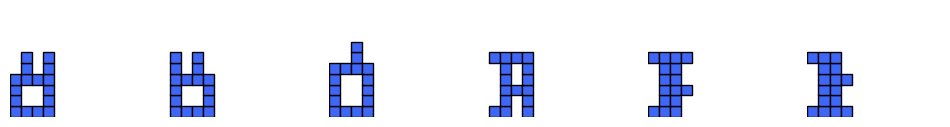

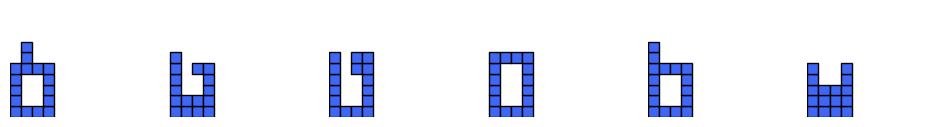

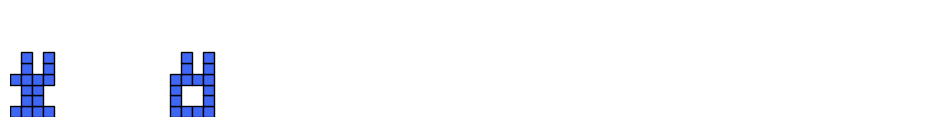

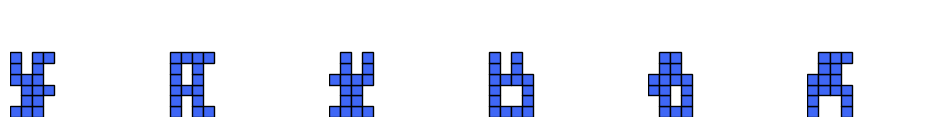

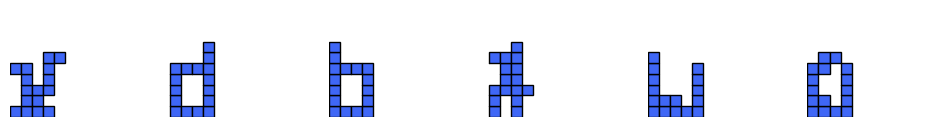

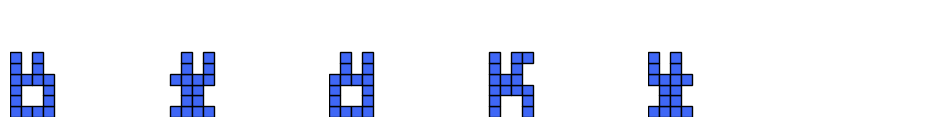

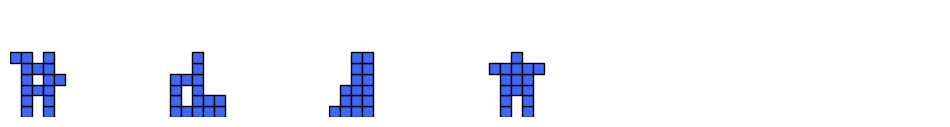

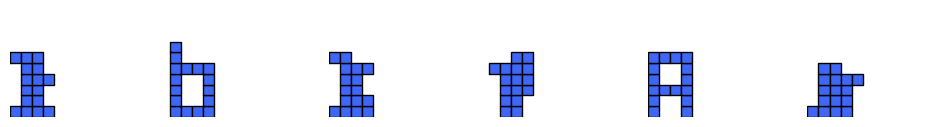

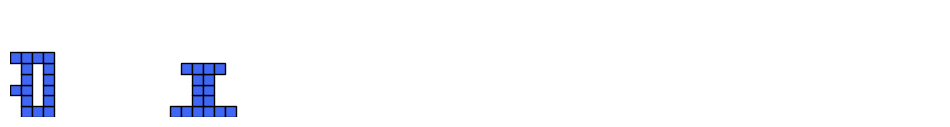

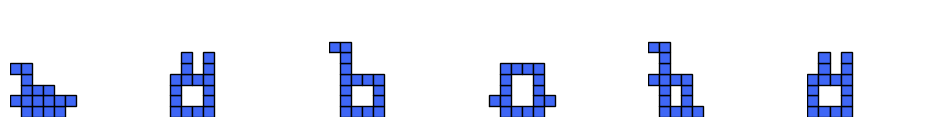

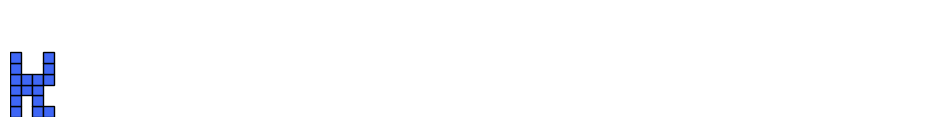

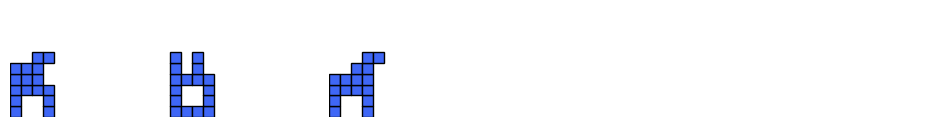

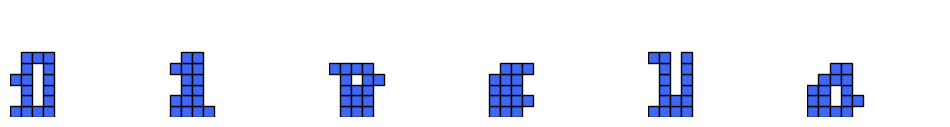

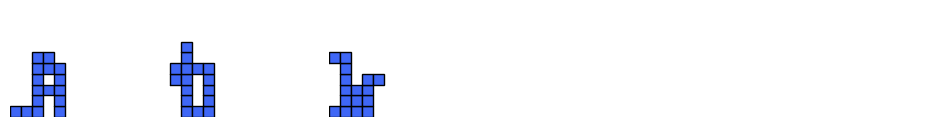

In [66]:
# render everyone's recalled towers
df_recalled_towers.groupby('gameID').apply(show_recalled_towers)

In [67]:
# df_recalled_towers_unique.groupby('gameID').apply(show_recalled_towers)

### Quantitatively measure accuracy of reconstructions

- Find distance between all reconstructions and targets
- Minimize total distance by finding best mapping (likely all reconstructions to some targets)
    - this assumes that people make one attempt at each tower
    - these scores will be low



#### Notes:

- We can use alignedTowerBlocks to get the reconstruction aligned to the left
- We can use this to find equal towers
- But we want to find the BEST alignment
- We want to find the *minimum*

In [68]:
# def getPrecision(arr1,arr2):
#     prod = np.multiply(arr1,arr2)
#     false_pos = np.subtract(arr2,prod)
#     numerator = np.sum(prod)
#     denominator = np.add(numerator,np.sum(false_pos))
#     recall = numerator/denominator
#     return recall

# def getRecall(arr1,arr2):
#     prod = np.multiply(arr1,arr2)
#     false_neg = np.subtract(arr1,prod)
#     numerator = np.sum(prod)
#     denominator = np.add(np.sum(prod),np.sum(false_neg))
#     recall = numerator/denominator
#     return recall

# def getF1Score(targetName, discreteWorld):
#     targetMap = targetMaps[targetName]
#     arr1 = 1*np.logical_not(np.array(targetMap))
#     arr2 = 1*np.logical_not(np.array(discreteWorld))
#     recall = getRecall(arr1, arr2)
#     precision = getPrecision(arr1, arr2)
#     numerator = np.multiply(precision, recall)
#     denominator = np.add(precision, recall)
#     if (denominator>0):
#         quotient = np.divide(numerator, denominator)
#         f1Score = np.multiply(2, quotient)
#     else:
#         f1Score = 0
#     return f1Score

# def getF1ScoreLambda(row):
#     return(getF1Score(row['targetName'], row['discreteWorld']))


# def getJaccard(targetName, discreteWorld):
#     targetMap = targetMaps[targetName]
#     arr1 = 1*np.logical_not(np.array(targetMap))
#     arr2 = 1*np.logical_not(np.array(discreteWorld))
    
#     prod = np.multiply(arr1,arr2)
#     true_pos = np.sum(prod)
#     false_pos = np.sum(np.subtract(arr2,prod))
#     false_neg = np.sum(np.subtract(arr1,prod))

#     denomenator = np.add(false_neg,np.add(false_pos,true_pos))
#     jaccard = np.divide(true_pos,denomenator)
#     return jaccard

# def getJaccardLambda(row):
#     return(getJaccard(row['targetName'], row['discreteWorld']))

#### preprocessing

In [69]:
from sklearn.metrics import f1_score

In [70]:
# remove duplicate towers

# find block map aligned to left
df_recalled_towers['alignedBlockMaps'] = \
    df_recalled_towers['alignedTowerBlocks'].apply(lambda x: utils.worldify(x, 
                                                                            world_width = 10,
                                                                            world_height = 12).block_map)

# make hashable
df_recalled_towers['alignedBlockMapsHashable'] = df_recalled_towers['alignedBlockMaps'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))

# consider towers the same if their corresponding block maps are identical
df_recalled_towers_unique = df_recalled_towers.sort_values(['nTower']).groupby(['gameID', 'alignedBlockMapsHashable']).first().reset_index()

print("removed {} duplicate towers".format(len(df_recalled_towers) - len(df_recalled_towers_unique)))

removed 7 duplicate towers


Target tower and recalled tower are both two dimensional arrays, aligned to the left.
We want to find the minimum distance between these.
LATER we'll find the best mapping based on these minimum distances.

To minimize this distance, we should scan each tower over each other.

In [71]:
def f1(arr1, arr2):
    assert arr1.shape == arr2.shape, "The input arrays must have the same shape"
    return f1_score(arr1.ravel(), arr2.ravel())

def distance(t1, t2, metric=f1_score):
    '''
    Returns distance between reconstruction and stim.
    '''
    return distance


def all_distances(t1, t2, metric=f1_score):
    '''
    Returns all distance between reconstruction and stim.
    '''
    return distances


def minimize_distances(t1, t2, metric=f1_score):
    '''
    Returns minimum distances between reconstruction and stim.
    '''
    return distance

#### find max width of recalled tower

In [72]:
def tower_width(block_map):
    index = np.argmax(np.where(block_map.sum(0) > 0))
    width = index + 1 # a little hacky- but should be fine
    return width

max_recall_width = df_recalled_towers_unique['alignedBlockMaps'].apply(tower_width).max()
stim_width = 4

print('widest recalled tower is of width ' + str(max_recall_width))
print('world for calculating max f1 score must {} wide'.format(str(max_recall_width + stim_width)))

widest recalled tower is of width 7
world for calculating max f1 score must 11 wide


In [73]:
def tower_height(block_map):
    index = np.argmax(np.where(block_map.sum(1) > 0))
    height = index + 1
#     height = index + 1 # a little hacky- but should be fine
    return height

max_recall_height = df_recalled_towers_unique['alignedBlockMaps'].apply(tower_height).max()
stim_height = 6

print('tallest recalled tower is of height ' + str(max_recall_height))
print('world for calculating max f1 score must {} wide'.format(str(max_recall_height + stim_height)))

tallest recalled tower is of height 8
world for calculating max f1 score must 14 wide


#### center stimuli

In [74]:
df_learn['alignedBlockMaps'] = df_learn['stimulus'].apply(lambda x: utils.worldify(x['blocks'], 
                                                   world_width = 10,
                                                   world_height = 12).block_map)

In [75]:
test_stim = df_learn['alignedBlockMaps'][0]
test_stim

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])

In [76]:
df_learn['alignedBlockMapsHashable'] = df_learn['alignedBlockMaps'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))

####  pad with zeros to ensure maximum f1 score found 
#### (ONLY DOING THIS WITH HORIZONTAL NOW)- could do with vertical as well later

In [77]:
def pad_array(arr, n_col, side="left"):
    # Number of rows in the array
    n_rows = arr.shape[0]

    # Create a column of 0s with the same number of rows
    zeros_column = np.zeros((n_rows, n_col))

    # Add the column of 0s to the right side of the array
    if side =="left":
        new_arr = np.hstack((zeros_column, arr))
    elif side =="right":
        new_arr = np.hstack((arr, zeros_column))
    else:
        raise(Exception)

    return new_arr

In [78]:
# add padding to left (max width of recall)
df_learn['paddedBlockMaps'] = df_learn['alignedBlockMaps'].apply(lambda x: pad_array(x, max_recall_width))

# add padding to right (gap )
right_padding = max(0, max_recall_width-6)
df_learn['paddedBlockMaps'] = df_learn['paddedBlockMaps'].apply(lambda x: pad_array(x, right_padding, side="right"))

In [79]:
df_learn['paddedBlockMaps'][0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0

In [80]:
df_recalled_towers_unique['paddedBlockMaps'] = df_recalled_towers_unique['alignedBlockMaps'].apply\
                                                (lambda x: pad_array(x, max_recall_width + right_padding, side="right"))

# df_recalled_towers_unique['paddedBlockMaps'][0]

In [81]:
def translate_tower(arr, dx, dy, fill_value = 0):
    """
    Translate a 2D NumPy array along the x and y axes.

    Args:
        arr (numpy.ndarray): 2D NumPy array.
        dx (int): Number of positions to translate along the x-axis.
        dy (int): Number of positions to translate along the y-axis.

    Returns:
        numpy.ndarray: Translated 2D NumPy array.
    """
    rows, cols = arr.shape
    translated_arr = np.full((rows, cols), fill_value)

    x_start = max(0, dx)
    x_end = cols + min(0, dx)
    y_start = max(0, dy)
    y_end = rows + min(0, dy)

    src_x_start = max(0, -dx)
    src_x_end = cols + min(0, -dx)
    src_y_start = max(0, -dy)
    src_y_end = rows + min(0, -dy)

    translated_arr[y_start:y_end, x_start:x_end] = arr[src_y_start:src_y_end, src_x_start:src_x_end]

    return translated_arr

In [82]:
def best_f1_score(target_tower, recalled_tower, scoring_fn = f1, render = False):
    '''
    Holds target_tower still, and tiles recalled_tower to find the best alignment that maximizes measure.
    Args:
        target_tower and recalled_tower: two arrays of equal dimensions
    
    Returns:
        maximum f1 score
    '''
    
    assert(np.array_equal(target_tower.shape, recalled_tower.shape))
    
    max_score = 0
    best_transformed = None
    overlay_map = None
    best_dx, best_dy = None, None
    
    dy = 0 # only allows dx translation right now
    
    for dx in range(0, target_tower.shape[0]):
        transformed_arr = translate_tower(recalled_tower, dx, dy)
        score = scoring_fn(target_tower, transformed_arr)
        if score > max_score:
                max_score = score
                best_transformed = transformed_arr
                overlay_map = transformed_arr + target_tower*3
                best_dx, best_dy = dx, dy

    if render:
        fig = plt.figure()
        plt.imshow(overlay_map, cmap='inferno')
        fig.gca().axis('off')

                
    return max_score, best_transformed, (best_dx, best_dy)

In [83]:
test_target = df_learn['paddedBlockMaps'][0]
test_target

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0

In [84]:
test_recall = df_recalled_towers_unique['paddedBlockMaps'][0]
test_recall

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 1., 1., 1

(0.75,
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]),
 (7, 0))

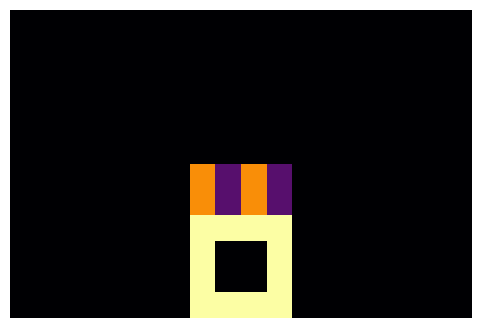

In [85]:
best_f1_score(test_target, test_recall, render=True)

Calculate f1 score for every (recalled_tower, stimulus) pair

In [86]:
def get_score_matrix(targets, recalls, distance_measure=best_f1_score, render = False):
    '''
    Returns distance matrix between 
    '''

    scores = targets.apply(lambda target: 
                recalls.apply(lambda recall: 
                    distance_measure(target['paddedBlockMaps'], recall['paddedBlockMaps'], render=render)[0], # just get score
                    axis=1),
                axis=1)

    return scores

In [87]:
def get_aligned_reconstructions(targets, recalls, distance_measure=best_f1_score, render = False):
    '''
    Returns block maps of reconstructions aligned to stims
    '''

    scores = targets.apply(lambda target: 
                recalls.apply(lambda recall: 
                    distance_measure(target['paddedBlockMaps'], recall['paddedBlockMaps'], render=render)[1], # just get score
                    axis=1),
                axis=1)

    return scores

In [88]:
from scipy.optimize import linear_sum_assignment

def maximal_mapping(distance_matrix):
    '''
    Takes a distance matrix and returns the assignment that maximizes the total score
    '''
    # returns a list, as long as the amount of columns, with each containing a row index
    # i.e. this will find the mapping of columns (recalls) to rows (targets), though not every row need be assigned to a target
    row_ind, col_ind = linear_sum_assignment(distance_matrix, maximize=True)
#     sorted_matrix = distance_matrix[:, optimal_assignment]
    return row_ind, col_ind

heatmaps of best_f1_score best_transformed  
heatmaps of best_f1_score best_transformed paired with matching stims 

### test/ visualize for one participant

In [89]:
n = 44

In [90]:
gameIDs = df_learn.gameID.unique()

# for each participant
for gameID in gameIDs[n:n+1]:
    
    # find stimuli
#     ppt_towers = df_learn[(df_learn.gameID == gameID)].tower_id.unique()
    df_ppt_learn = df_learn[(df_learn.gameID == gameID)].groupby('tower_id').first()
    
    assert(len(df_ppt_learn) == 6)
    
    # find recalled towers
    df_ppt_recall = df_recalled_towers_unique[df_recalled_towers_unique.gameID == gameID].groupby("nTower").first()
    
    ppt_scores = get_score_matrix(df_ppt_learn, df_ppt_recall, render = False)
    ppt_maps = get_aligned_reconstructions(df_ppt_learn, df_ppt_recall)
    
    # calculate optimal assignment
    row_ind, col_ind = maximal_mapping(ppt_scores)
    
    assignment_dict = dict(zip(df_ppt_recall.index[col_ind], ppt_scores.index[row_ind]))
    
ppt_scores

nTower,1,2,3,4,5,6
tower_id,,,,,,
talls_097_100,0.9375,0.6875,0.6875,0.7500,0.7500,0.7500
talls_100_097,0.6875,0.6875,0.6250,0.8750,0.7500,0.6875
talls_114_111,0.7500,0.5000,0.8750,0.6250,0.6875,0.7500
talls_116_100,0.7500,0.7500,0.7500,0.7500,0.7500,0.8125
talls_118_114,0.8750,0.6250,0.6250,0.5625,0.8125,0.6250
talls_121_101,0.8125,0.6875,0.7500,0.8125,0.7500,0.8750


5955-c71bea47-b459-49a5-b5a9-69ce06110ee0
5955-c71bea47-b459-49a5-b5a9-69ce06110ee0


""


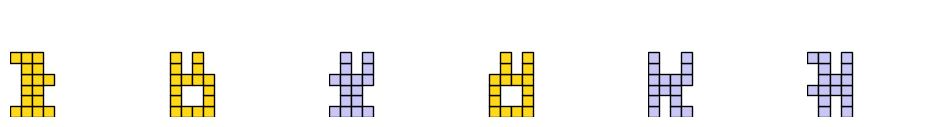

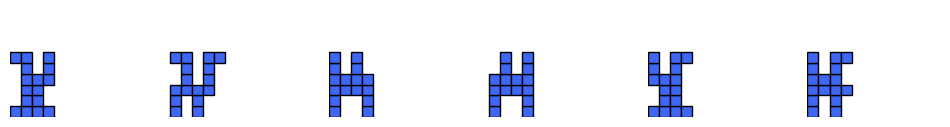

In [91]:
df_learn.query("gameID=='{}'".format(gameIDs[n])).sort_values(['gameID','trial_start_time']).groupby('gameID').apply(show_target_towers)
df_recalled_towers.query("gameID=='{}'".format(gameIDs[n])).sort_values('nTower').groupby('gameID').apply(show_recalled_towers)



### Visualize reconstructions

In [92]:
df_recalled_towers_unique['bestMatch'] = 'unassigned'
df_recalled_towers_unique['bestMatchF1'] = np.NaN
df_recalled_towers_unique['bestMatchCondition'] = 'unassigned'
df_recalled_towers_unique['bestMatchAlignment'] = 'unassigned'

# df_recalled_towers_unique['bestMatchAlignment'] = df_recalled_towers_unique['bestMatchAlignment'].astype(object)

In [93]:
# hack to store arrays as elements
class AlignedBlockMap:
    def __init__(self, arr):
        self.arr = arr

In [94]:
gameIDs = df_learn.gameID.unique()

# for each participant
for gameID in gameIDs:
    
    # find stimuli
    df_ppt_learn = df_learn[(df_learn.gameID == gameID)].groupby('tower_id').first()
    
    assert(len(df_ppt_learn) == 6)
    
    # find recalled towers
    df_ppt_recall = df_recalled_towers_unique[df_recalled_towers_unique.gameID == gameID].groupby("nTower").first()
    
    ppt_scores = get_score_matrix(df_ppt_learn, df_ppt_recall)
    ppt_maps = get_aligned_reconstructions(df_ppt_learn, df_ppt_recall)
    
    # calculate optimal assignment
    row_ind, col_ind = maximal_mapping(ppt_scores)
    
    assignment_dict = dict(zip(df_ppt_recall.index[col_ind], ppt_scores.index[row_ind]))
    
    for i, (nTower, towerID) in enumerate(assignment_dict.items()):
        df_recalled_towers_unique.loc[(df_recalled_towers_unique.gameID==gameID) & 
                                  (df_recalled_towers_unique.nTower==int(nTower)),'bestMatch'] = towerID
        
        df_recalled_towers_unique.loc[(df_recalled_towers_unique.gameID==gameID) & 
                                  (df_recalled_towers_unique.nTower==int(nTower)),'bestMatchF1'] = \
                        ppt_scores.loc[towerID,nTower]
        
        df_recalled_towers_unique.loc[(df_recalled_towers_unique.gameID==gameID) & 
                                  (df_recalled_towers_unique.nTower==int(nTower)),'bestMatchAlignment'] =\
                        AlignedBlockMap(ppt_maps.loc[towerID, nTower])

        df_recalled_towers_unique.loc[(df_recalled_towers_unique.gameID==gameID) & 
                                  (df_recalled_towers_unique.nTower==int(nTower)),'bestMatchCondition'] = \
                        df_ppt_learn.loc[towerID,'condition']
    

In [95]:
df_recalled_towers_unique['bestMatchAlignment'] = df_recalled_towers_unique['bestMatchAlignment'].apply(lambda x: x.arr)

In [96]:
def showDiscreteMap(row, ax, vmax=None, **kwargs):
#     world_maps = df.apply(lambda row: row)
    n = row.shape[0]
    av_map = np.add.reduce(np.array(row))/n
#     av_map = np.add.reduce(np.array(row))
#     av_map = np.rot90(av_map)/n
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                **kwargs)
    else:
        ax.imshow(av_map,
                **kwargs)

In [97]:
stim_maps = df_learn.groupby('tower_id').first().reset_index()[['tower_id','paddedBlockMaps']]

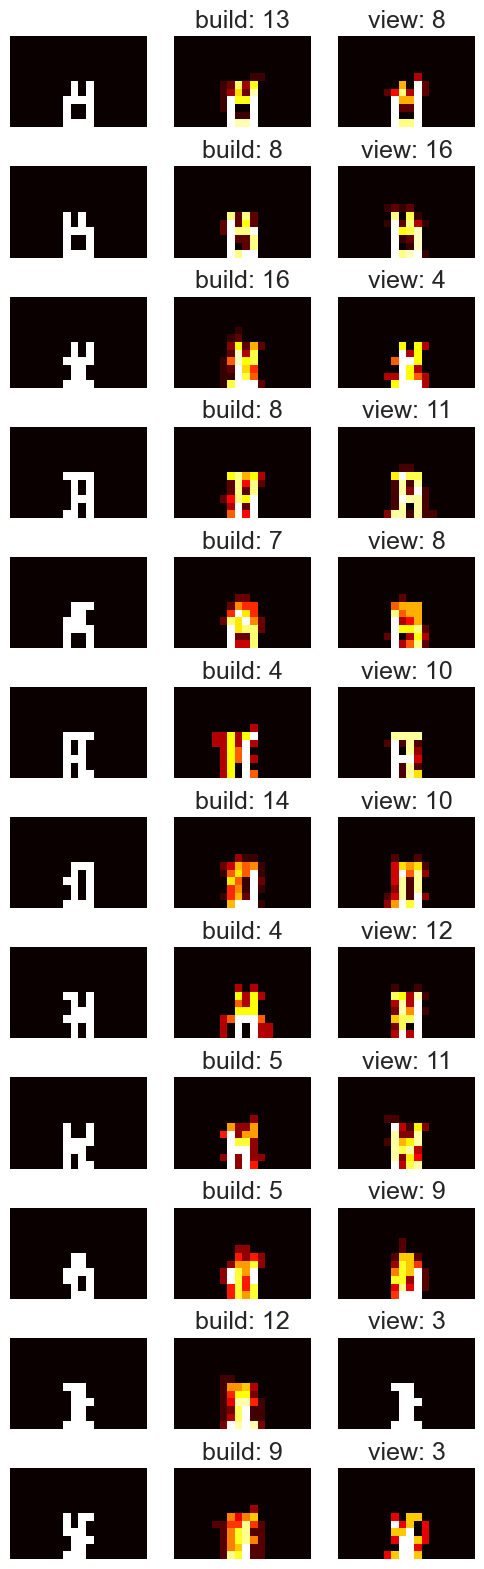

In [98]:
tower_ids = df_recalled_towers_unique.bestMatch.unique()

fig, axs = plt.subplots(nrows=len(tower_ids), ncols=3, figsize=(6, 20))  

for (i, tower_id) in enumerate(tower_ids):
    axs[i,0].axis('off')
    showDiscreteMap(stim_maps[(stim_maps.tower_id == tower_id)]['paddedBlockMaps'], 
                    axs[i, 0],
                    cmap= 'hot',)

for (j, condition) in enumerate(['build','view']):
    for (i, tower_id) in enumerate(tower_ids):
        subset = df_recalled_towers_unique[(df_recalled_towers_unique.bestMatch == tower_id) & 
                                                  (df_recalled_towers_unique.bestMatchCondition == condition)]['bestMatchAlignment']
        axs[i,j+1].axis('off')
        axs[i,j+1].set_title(condition + ': ' + str(len(subset)))
        showDiscreteMap(subset, 
                        axs[i, j+1],
                        cmap= 'hot',)

plt.savefig('heatmaps.pdf', format='pdf')



In [99]:
matplotlib.colors.Colormap('hot')

In [100]:
cmap = matplotlib.colors.Colormap('hot')
#norm = colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

#cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

plt.show()
# fig.savefig('color_bar.pdf')

<Figure size 600x100 with 1 Axes>

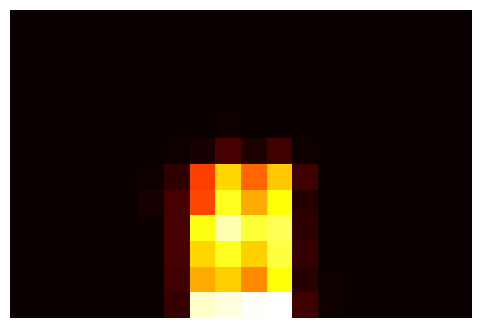

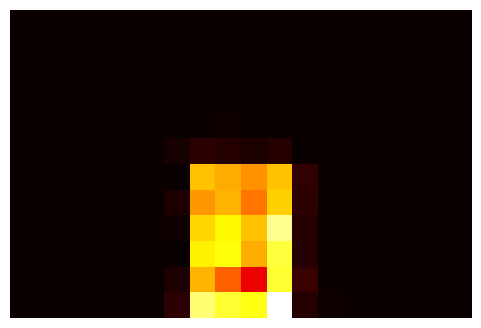

In [101]:
# overall condition comparison

fig, ax = plt.subplots()
ax.axis('off')
showDiscreteMap(df_recalled_towers_unique[df_recalled_towers_unique.bestMatchCondition == 'build']['bestMatchAlignment'], ax, cmap= 'hot',)


fig, ax = plt.subplots()
ax.axis('off')
showDiscreteMap(df_recalled_towers_unique[df_recalled_towers_unique.bestMatchCondition == 'view']['bestMatchAlignment'], ax, cmap= 'hot',)

In [102]:
# bestMatchConditionCounts = df_recalled_towers_unique.groupby(['gameID','bestMatchCondition']).count()['experimentName'].reset_index()
# bestMatchConditionCounts = bestMatchConditionCounts.rename(columns={'experimentName': 'nMatched'})


In [103]:
# group the DataFrame by 'gameID' and 'bestMatchCondition', and count the rows
grouped = df_recalled_towers_unique.groupby(['gameID','bestMatchCondition']).agg({'experimentName':'count',
                                                                                 'bestMatchF1':'mean'})
# Get all unique values for each column
gameIDs = df_recalled_towers_unique['gameID'].unique()
conditions = df_recalled_towers_unique['bestMatchCondition'].unique()

# Create a DataFrame with all possible combinations of the unique values
all_combinations = pd.MultiIndex.from_product([gameIDs, conditions], names=['gameID', 'bestMatchCondition']).to_frame(index=False)

# Merge the DataFrame with all combinations and the grouped DataFrame
merged = all_combinations.merge(grouped, on=['gameID', 'bestMatchCondition'], how="left")

merged['experimentName'] = merged['experimentName'].fillna(0)
merged['bestMatchF1'] = merged['bestMatchF1'].fillna(np.NaN)
merged = merged.rename(columns={'experimentName':'nMatched',
                       'bestMatchF1':'bestMatchF1Mean'})

bestMatchConditionCounts = merged

In [104]:
# leave out participants who don't have at least one recall tower in each condition. find diff between f1. 
# Do paired t-test.

def built_both(df):
    built = df.loc[df.bestMatchCondition == 'build','nMatched'].iloc[0]
    viewed = df.loc[df.bestMatchCondition == 'view','nMatched'].iloc[0]
    
    both = (built > 0) & (viewed > 0)
    
    return both

built_both = bestMatchConditionCounts.groupby(['gameID']).apply(lambda group: built_both(group))

bestMatchConditionCounts.loc[:,'built_both'] = bestMatchConditionCounts.gameID.isin(list(built_both[built_both].index))

In [105]:
bestMatchConditionCounts

,gameID,bestMatchCondition,nMatched,bestMatchF1Mean,built_both
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,build,3.0,0.958333,True
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,view,3.0,0.791667,True
2,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,build,2.0,0.812500,True
3,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,view,2.0,0.812500,True
4,0617-9ddb7997-5774-4c33-849a-ab70289df180,build,0.0,NaN,False
...,...,...,...,...,...
95,9343-013fb2db-94d6-4c42-b102-167d834d6e0b,view,1.0,1.000000,True
96,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,build,3.0,0.791667,True
97,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,view,3.0,0.812500,True
98,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,build,2.0,0.812500,True


In [186]:
list(np.arange(0.1,1,0.05))

[0.1,
 0.15000000000000002,
 0.20000000000000004,
 0.25000000000000006,
 0.30000000000000004,
 0.3500000000000001,
 0.40000000000000013,
 0.45000000000000007,
 0.5000000000000001,
 0.5500000000000002,
 0.6000000000000002,
 0.6500000000000001,
 0.7000000000000002,
 0.7500000000000002,
 0.8000000000000002,
 0.8500000000000002,
 0.9000000000000002,
 0.9500000000000003]

### construct dataframe where each stimulus gets all the information about the best matching recall tower

In [205]:
df_learn_unique = df_learn[df_learn.rep==1].reset_index(drop=True)
df_learn_unique_paired = df_learn_unique.merge(df_recalled_towers_unique, 
                                               how='left', 
                                               left_on=['gameID','tower_id'], 
                                               right_on=['gameID','bestMatch']).reset_index(drop=True)
                      
default_values = {
    'C_id': -1,     # default for C_id
    'bestMatch': 'no_match',     # default for D_id
    'bestMatchF1': 0,
    'perfectMatch': False
    
#     'value2': 'default_value'  # default for value2
}

df_learn_unique_paired.fillna(value=default_values, inplace=True)

for threshold in list(np.arange(0.1,1,0.05)):
    df_learn_unique_paired.loc[:, f'matched_meeting_threshold_{threshold:.2f}'] = df_learn_unique_paired['bestMatchF1'] > threshold
    
df_learn_unique_paired.loc[:, 'matched_to_any'] = df_learn_unique_paired['bestMatchF1'] > 0

In [206]:
df_learn_unique_paired.perfectMatch

0      False
1      False
2      False
3      False
4      False
       ...  
295    False
296    False
297    False
298    False
299    False
Name: perfectMatch, Length: 300, dtype: bool

In [207]:
df_learn_unique_paired.to_csv('{}/df_learn_unique_paired.csv'.format(experiment_results_dir))

### Visualize mapping from recalled tower to condition

In [106]:
df_recall_condition = df_recalled_towers_unique[['gameID','nTower', 'bestMatchCondition']]\
                        .sort_values(['gameID','nTower'])
df_recall_condition

,gameID,nTower,bestMatchCondition
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,1,build
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,2,build
5,0403-00b72085-5f9c-4337-bec4-04dd488251fa,3,view
3,0403-00b72085-5f9c-4337-bec4-04dd488251fa,4,build
2,0403-00b72085-5f9c-4337-bec4-04dd488251fa,5,view
...,...,...,...
203,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,5,view
205,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,6,view
207,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,1,view
209,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,2,build


In [107]:
df_recall_map = df_recall_condition.pivot(columns='nTower', values='bestMatchCondition',index='gameID')

In [108]:
# Define a custom colormap
colors = ['white', poster_plot_settings.BLUE, poster_plot_settings.RED]
cmap = ListedColormap(colors)

[Text(1, 0, 'None/ repeat'), Text(1, 1, 'build'), Text(1, 2, 'view')]

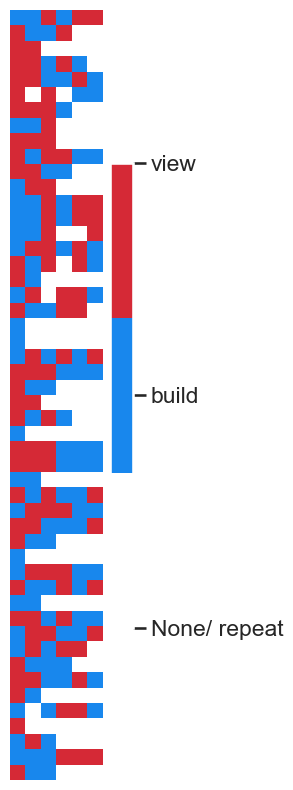

In [109]:
mapping = {np.NaN: 0.0, 
           'build': 1.0, 
           'view': 2.0}

df_recall_map_float = np.vectorize(mapping.get)(df_recall_map)

fig = plt.figure(figsize=(2,10))
plt.imshow(df_recall_map_float, cmap=cmap)
fig.gca().axis('off')

cbar = plt.colorbar(ticks=range(len(colors)))
cbar.ax.set_yticklabels(['None/ repeat', 'build','view'])



In [110]:
df_recalled_towers_unique

,gameID,alignedBlockMapsHashable,Unnamed: 0,_id,experimentName,iterationName,workerID,studyLocation,n_resets_for_tower,n_undo_for_tower,...,datatype,n_block,cumulative_resets_across_submissions,tower_details,alignedBlockMaps,paddedBlockMaps,bestMatch,bestMatchF1,bestMatchCondition,bestMatchAlignment
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,"((0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, ...",64,64404bebda7c3649c9c291a2,block_construction_build_components,build_components_build_recall_prolific_pilot_6...,5eca536f9aa4f658d641a7d9,Prolific,0,0,...,recalled_tower,8,0,"{'blocks': [{'x': 3, 'y': 0, 'width': 2, 'heig...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",talls_100_097,1.0000,build,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,"((0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, ...",62,64404bd5da7c3649c9c29151,block_construction_build_components,build_components_build_recall_prolific_pilot_6...,5eca536f9aa4f658d641a7d9,Prolific,0,0,...,recalled_tower,8,0,"{'blocks': [{'x': 3, 'y': 0, 'width': 2, 'heig...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",talls_114_111,1.0000,build,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,0403-00b72085-5f9c-4337-bec4-04dd488251fa,"((0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, ...",78,64404cc1da7c3649c9c293ba,block_construction_build_components,build_components_build_recall_prolific_pilot_6...,5eca536f9aa4f658d641a7d9,Prolific,0,0,...,recalled_tower,8,0,"{'blocks': [{'x': 3, 'y': 0, 'width': 2, 'heig...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",talls_097_100,0.7500,view,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,0403-00b72085-5f9c-4337-bec4-04dd488251fa,"((0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, ...",77,64404c9bda7c3649c9c29372,block_construction_build_components,build_components_build_recall_prolific_pilot_6...,5eca536f9aa4f658d641a7d9,Prolific,0,13,...,recalled_tower,8,0,"{'blocks': [{'x': 3, 'y': 0, 'width': 2, 'heig...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",talls_118_121,0.8750,build,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0403-00b72085-5f9c-4337-bec4-04dd488251fa,"((0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, ...",79,64404cdeda7c3649c9c293f6,block_construction_build_components,build_components_build_recall_prolific_pilot_6...,5eca536f9aa4f658d641a7d9,Prolific,0,0,...,recalled_tower,8,0,"{'blocks': [{'x': 3, 'y': 0, 'width': 1, 'heig...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",talls_102_126,0.6250,view,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,"((0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, ...",111,64404f00da7c3649c9c29728,block_construction_build_components,build_components_build_recall_prolific_pilot_6...,60461bfeeac81b04cf62f7a6,Prolific,0,0,...,recalled_tower,8,1,"{'blocks': [{'x': 4, 'y': 0, 'width': 2, 'heig...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",talls_097_118,1.0000,view,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
206,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,"((0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, ...",90,64404dc1da7c3649c9c29581,block_construction_build_components,build_components_build_recall_prolific_pilot_6...,60461bfeeac81b04cf62f7a6,Prolific,1,0,...,recalled_tower,8,1,"{'blocks': [{'x': 5, 'y': 0, 'width': 2, 'heig...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",talls_097_100,0.8125,build,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
207,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,"((0, 0, 0, 0, 0, 0,

(array([ 3.,  6., 17., 14.,  0., 31., 28., 25., 13., 73.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 10 artists>)

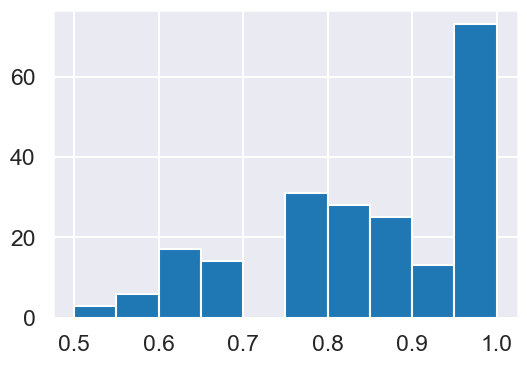

In [111]:
# Maybe we shouldn't treat all reconstructions as equal
# there seems to be a trimodal distribution, with a natural division at around 0.75
plt.hist(df_recalled_towers_unique.bestMatchF1, bins=10)

In [112]:
# mark the perfect reconstructions
df_recalled_towers_unique.loc[:,'perfectMatch'] = df_recalled_towers_unique.bestMatchF1 == 1.0

# mark the good reconstructions
df_recalled_towers_unique.loc[:,'goodMatch'] = df_recalled_towers_unique.bestMatchF1 > 0.75

In [113]:
df_recalled_towers_unique.to_csv('{}/dfRecalledTowersUnique.csv'.format(experiment_results_dir))

In [114]:
bestMatchConditionCounts.to_csv('{}/bestMatchConditionCounts.csv'.format(experiment_results_dir))

In [115]:
condition_diffs = bestMatchConditionCounts.groupby('gameID').apply(\
                    lambda df: df.loc[df['bestMatchCondition'] == 'build', 'nMatched'].reset_index(drop=True)\
                             - df.loc[df['bestMatchCondition'] == 'view', 'nMatched'].reset_index(drop=True))

condition_diffs.value_counts()

 0.0    26
 1.0    10
-1.0     7
-2.0     3
 2.0     3
-3.0     1
Name: count, dtype: int64

In [118]:
bestMatchConditionCounts

,gameID,bestMatchCondition,nMatched,bestMatchF1Mean,built_both
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,build,3.0,0.958333,True
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,view,3.0,0.791667,True
2,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,build,2.0,0.812500,True
3,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,view,2.0,0.812500,True
4,0617-9ddb7997-5774-4c33-849a-ab70289df180,build,0.0,NaN,False
...,...,...,...,...,...
95,9343-013fb2db-94d6-4c42-b102-167d834d6e0b,view,1.0,1.000000,True
96,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,build,3.0,0.791667,True
97,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,view,3.0,0.812500,True
98,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,build,2.0,0.812500,True


In [119]:
# Calculate 95% CI for each group
def calculate_ci(data, conf_level=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = sem * stats.t.ppf((1 + conf_level) / 2, len(data) - 1)
    return ci

In the next few cells we compare towers that were matched to build condition stimuli with those matched to build stimuli.  

We match all of the reconstructions to targets, but can consider a subset of these that meet some threshold F1 score.

**One question here is: what is a baseline F1 score that we would expect if they didn't actually remember the tower?**
There are a few ways of calculating this. We could randomly place 8 blocks. We could do so in the target region (all towers fit within a 6\*8 rectangle). We could calculate the average across reconstructions.

#### Compare number of recalled towers (with options for different accuracy cutoffs) 

Effect seems to get larger when considering accurate matches only (change `subset`)

(0.0, 3.0)

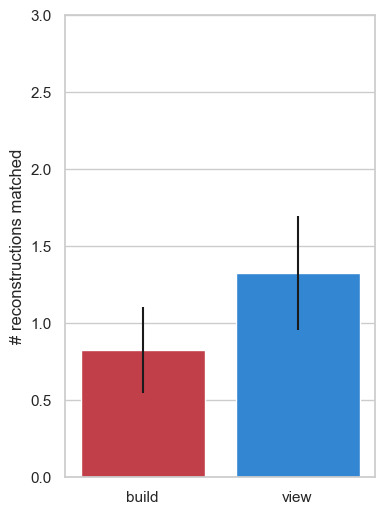

In [652]:
subset = df_recalled_towers_unique # all reconstructions
subset = df_recalled_towers_unique[df_recalled_towers_unique.goodMatch] # good
subset = df_recalled_towers_unique[df_recalled_towers_unique.perfectMatch] # perfect

subset_condition_counts = subset.groupby(['gameID','bestMatchCondition']).size().reset_index(name='count')

# Create the multi-level index containing all possible combinations
all_gameIDs = subset['gameID'].unique()
all_conditions = subset['bestMatchCondition'].unique()
multi_index = pd.MultiIndex.from_product([all_gameIDs, all_conditions], names=['gameID', 'bestMatchCondition'])

# Reindex and fill missing rows with zero
subset_condition_counts.set_index(['gameID', 'bestMatchCondition'], inplace=True)
subset_condition_counts = subset_condition_counts.reindex(multi_index).fillna(0).reset_index()

subset_condition_counts
ci_build =  calculate_ci(subset_condition_counts[subset_condition_counts["bestMatchCondition"] == "build"]["count"])
ci_view =  calculate_ci(subset_condition_counts[subset_condition_counts["bestMatchCondition"] == "view"]["count"])
ci = [ci_build, ci_view]

sns.barplot(data = subset_condition_counts,
            y = "count",
            x = "bestMatchCondition",
            palette = palette,
            errorbar=None,
            yerr=ci
            )

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)


# plt.title("n matched targets")
plt.xlabel('')
plt.ylabel("# reconstructions matched")
plt.ylim((0,3))
# plt.yticks(fontsize=15)
# plt.yticks(fontsize=15)

# plt.show()


# plt.savefig('../results/build_components/plots/build_recall_condition_matches.pdf', bbox_inches='tight')


In [578]:
importlib.reload(poster_plot_settings)

<module 'poster_plot_settings' from '/Users/will/bc_perception/analysis/build_components/poster_plot_settings.py'>

#### Sum of F1 scores across reconstructions (with options for different accuracy cutoffs) 
Effect seems to get larger when considering accurate matches only

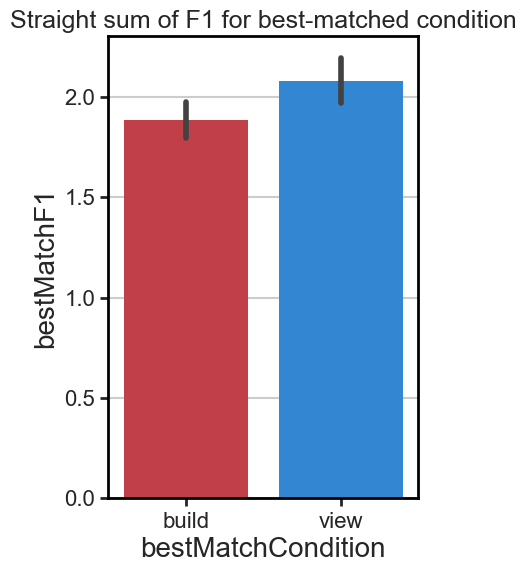

In [579]:
# sums for a subset of reconstructions

subset = df_recalled_towers_unique
# subset = df_recalled_towers_unique[df_recalled_towers_unique.perfectMatch] # perfect
# subset = df_recalled_towers_unique[df_recalled_towers_unique.goodMatch] # good

f1_sums_subset = subset.groupby(['gameID','bestMatchCondition'])['bestMatchF1'].sum().reset_index()

fig = plt.figure()

sns.barplot(data = f1_sums_subset,
                y = "bestMatchF1",
                x = "bestMatchCondition",
                palette = palette,
                errorbar="se",)

plt.title("Straight sum of F1 for best-matched condition")

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)


plt.legend([],[], frameon=False)

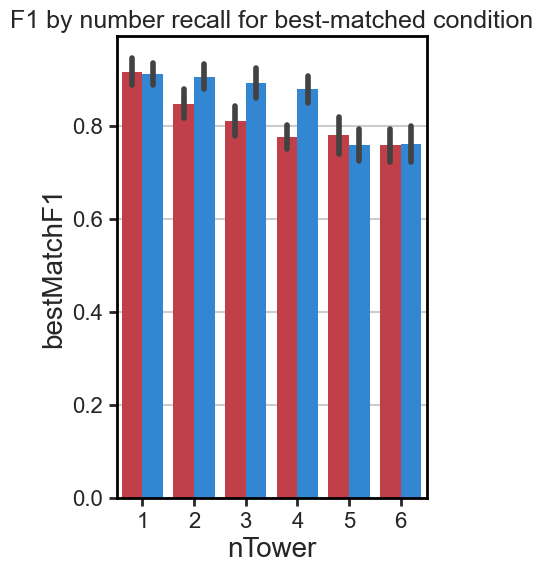

In [580]:
fig = plt.figure()

sns.barplot(data = df_recalled_towers_unique,
                y = "bestMatchF1",
                hue = "bestMatchCondition",
                x = "nTower",
                errorbar="se",
                palette = palette)

plt.title("F1 by number recall for best-matched condition")

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)


plt.legend([],[], frameon=False)

#### Mean accuracy across conditions (with options for different accuracy cutoffs) 

Effect seems to get *smaller* when considering accurate matches only. We'd expect this, as it pushes everything towards F1=1.

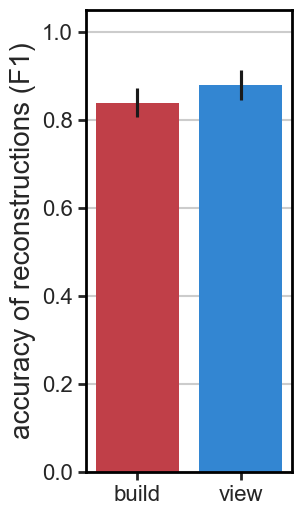

In [581]:
# mean f1

subset = df_recalled_towers_unique # all
# subset = df_recalled_towers_unique[df_recalled_towers_unique.goodMatch] # good
# subset = df_recalled_towers_unique[df_recalled_towers_unique.perfectMatch] # perfect

f1_means_subset = subset.groupby(['gameID','bestMatchCondition'])['bestMatchF1'].mean().reset_index()

ci_build =  calculate_ci(f1_means_subset[f1_means_subset["bestMatchCondition"] == "build"]["bestMatchF1"])
ci_view =  calculate_ci(f1_means_subset[f1_means_subset["bestMatchCondition"] == "view"]["bestMatchF1"])
ci = [ci_build, ci_view]

fig, ax = plt.subplots(figsize=(4/(3/2),6))

sns.barplot(data = f1_means_subset,
                y = "bestMatchF1",
                x = "bestMatchCondition",
                palette = palette,
#                 errorbar="se",
                errorbar=None,
#                 capsize=0.2, 
                yerr=ci)

# ppt_lines = sns.lineplot(data = f1_means_subset,
#                          ax= ax,
#                          y = "bestMatchF1",
#                          x = "bestMatchCondition",
#                          hue = "gameID",
#                          palette=["#222"],
#                          alpha=0.3,
#                          linewidth=1
#                         )

plt.legend([],[], frameon=False)
plt.ylabel("accuracy of reconstructions (F1)")
plt.xlabel('')
plt.ylim((0,1.05))

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)

plt.legend([],[], frameon=False)
plt.savefig('../results/build_components/plots/build_recall_condition_accuracy.pdf', bbox_inches='tight')

## Compare how people built stimuli across matched conditions

We've made our best guesses about which stimuli people were trying to build in the recall phase.  
Now we can ask whether there was anything different about the building process for each of these categories (build matches and view matches)

#### Mean build time across conditions

On first appearances, it looks like people built build stimuli slightly faster than view ones.
Moreove, this effect seems to get *larger* when we limit our attention to more accurate matches (i.e. the ones we can be more confident were remembered well).

This suggests that a part of what we remember when we build an object is the procedure we used to construct it.

In [122]:
rt_means = df_recalled_towers_unique.groupby(['gameID','bestMatchCondition'])['time_since_last_submit'].mean().reset_index()

<Figure size 600x400 with 0 Axes>

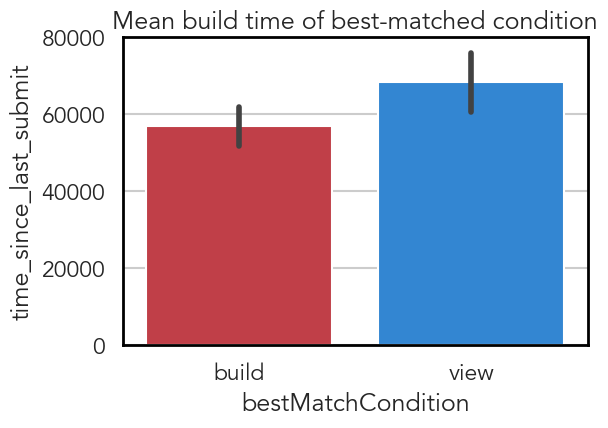

In [127]:
# here we can look at sets of reconstructions that are increasingly restricted to higher levels of accuracy

subset = df_recalled_towers_unique # all
# subset = df_recalled_towers_unique[df_recalled_towers_unique.goodMatch] # good
# subset = df_recalled_towers_unique[df_recalled_towers_unique.perfectMatch] # perfect


rt_means_subset = subset.groupby(['gameID','bestMatchCondition'])['time_since_last_submit'].mean().reset_index()

fig = plt.figure()

fig = plt.figure()

sns.barplot(data = rt_means_subset,
                y = "time_since_last_submit",
                x = "bestMatchCondition",
                palette = palette,
                errorbar="se",)

plt.title("Mean build time of best-matched condition")

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)

plt.ylim((0,80000))

plt.legend([],[], frameon=False)

Here we compare accuracy bins (from very innaccurate reconstructions that we wouldn't necessarily want to consider as remembered, to very accurate and perfect reconstructions).

As we consider more and more accurate reconstructions, time to reconstruct build stimuli goes down, and time to build view stimuli goes up.  
i.e. it looks like there is an interaction between F1 score and build time.

In [128]:
# Define bin edges
bins = [0, 0.6, 0.7, 0.8, 0.9, 1.1]

# Define bin labels
labels = ['0-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1']

# Create bins
df_recalled_towers_unique['bestMatchF1Bin'] = pd.cut(df_recalled_towers_unique['bestMatchF1'], bins=bins, labels=labels, right=False)


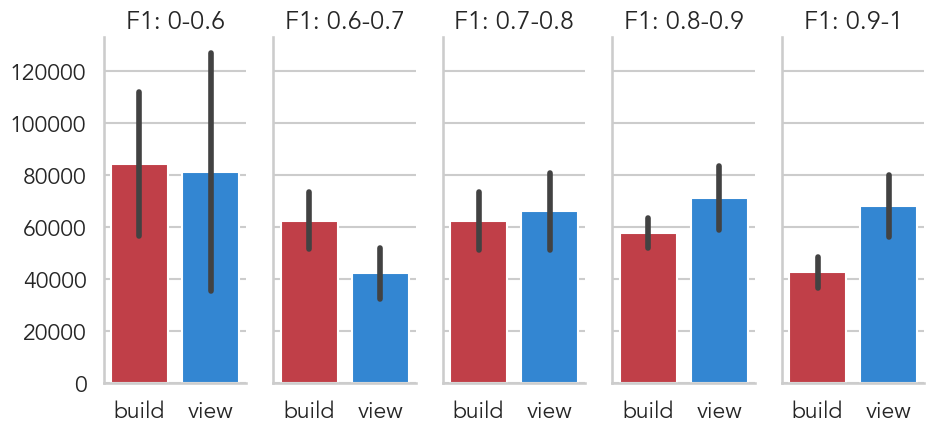

In [129]:
g = sns.catplot(data = df_recalled_towers_unique,
                y = "time_since_last_submit",
                x = "bestMatchCondition",
                col = "bestMatchF1Bin",
                kind="bar",
                palette = palette,
                errorbar="se",
                aspect=0.4)

plt.title("Mean build time of best-matched condition")

g.set_titles("F1: {col_name}")  # This will set only the value of the bestMatchF1Bin for column titles
g.set_axis_labels("", "")   # This will remove both x and y axis labels. If you want to remove only x-axis label, use ("", "Desired Y-label")
sns.set_context(font_scale=1) 

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)

# plt.ylim((0,80000))

plt.legend([],[], frameon=False)

#### create dataframes for stats NOTE: I THINK THIS ISN'T CURRENTLY USED- delete?

In [130]:
bestMatchConditionCounts

,gameID,bestMatchCondition,nMatched,bestMatchF1Mean,built_both
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,build,3.0,0.958333,True
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,view,3.0,0.791667,True
2,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,build,2.0,0.812500,True
3,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,view,2.0,0.812500,True
4,0617-9ddb7997-5774-4c33-849a-ab70289df180,build,0.0,NaN,False
...,...,...,...,...,...
95,9343-013fb2db-94d6-4c42-b102-167d834d6e0b,view,1.0,1.000000,True
96,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,build,3.0,0.791667,True
97,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,view,3.0,0.812500,True
98,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,build,2.0,0.812500,True


In [131]:
bestMatchConditionCountsBuiltBoth = bestMatchConditionCounts[bestMatchConditionCounts.built_both]

In [132]:
f1_diffs = bestMatchConditionCountsBuiltBoth.groupby('gameID').apply(\
                    lambda df: df.loc[df['bestMatchCondition'] == 'build', 'bestMatchF1Mean'].reset_index(drop=True)\
                             - df.loc[df['bestMatchCondition'] == 'view', 'bestMatchF1Mean'].reset_index(drop=True))

In [133]:
bestMatchConditionCounts[bestMatchConditionCounts.built_both].groupby(['gameID','bestMatchCondition'])['bestMatchF1Mean']


In [134]:
# no need to make df- just use df_recalled_towers_unique.
# find average F1 for each participant/ condition. 
# Do unpaired t-test.

#### Create baseline

Create baseline distribution of F1 scores with random mapping from reconstructions to targets

In [135]:
import random

In [136]:
# calculate baseline distribution by shuffling assignments for each participants niter times

df_baseline_f1 = pd.DataFrame()

iters = 50

random.seed(0)

gameIDs = df_learn.gameID.unique()

ppt_scores_dict = {}
assignments_dict = {}

# for each participant
for gameID in gameIDs:
    
    # find stimuli
    df_ppt_learn = df_learn[(df_learn.gameID == gameID)].groupby('tower_id').first()
    
    assert(len(df_ppt_learn) == 6)
    
    # find recalled towers
    df_ppt_recall = df_recalled_towers_unique[df_recalled_towers_unique.gameID == gameID].groupby("nTower").first()
    
    ppt_scores_dict[gameID] = get_score_matrix(df_ppt_learn, df_ppt_recall)
#     ppt_maps = get_aligned_reconstructions(df_ppt_learn, df_ppt_recall)
    
    assignments_dict[gameID] = {}
    
    for i in range(iters):
        
#         print(ppt_scores_dict[gameID].shape)
        
        row_ind = list(range(ppt_scores_dict[gameID].shape[0]))
        col_ind = list(range(ppt_scores_dict[gameID].shape[1]))
        random.shuffle(col_ind) # randomize assignment
        
#         print(row_ind, col_ind)

        assignments_dict[gameID][i] = {}
        assignments_dict[gameID][i]['row_ind'] = row_ind
        assignments_dict[gameID][i]['col_ind'] = col_ind
        assignments_dict[gameID][i]['assignment'] = dict(zip(np.array(ppt_scores_dict[gameID].columns)[col_ind], ppt_scores_dict[gameID].index[row_ind]))
        
#         print(assignment)
        assignments_dict[gameID][i]['F1s'] = []
    
        for j, (nTower, towerID) in enumerate(assignments_dict[gameID][i]['assignment'].items()):
            
#             print(ppt_scores_dict[gameID])
            
            assignments_dict[gameID][i]['F1s'].append(ppt_scores_dict[gameID].loc[towerID, nTower])
        
            
            df_baseline_f1 = pd.concat([df_baseline_f1, pd.Series({
                'gameID' : gameID,
                'iter' : i,
                'recall_attempt': nTower,
                'tower_id': towerID,
                'F1': ppt_scores_dict[gameID].loc[towerID, nTower]}).to_frame().T], ignore_index=True)
            

In [137]:
df_learn_rep_1 = df_learn[df_learn.rep==1].reset_index(drop=True)

In [138]:
df_baseline_f1 = df_baseline_f1.merge(df_learn_rep_1[['gameID', 'tower_id','condition']], on = ['gameID', 'tower_id'], how='left')
df_baseline_f1

,gameID,iter,recall_attempt,tower_id,F1,condition
0,3078-670e6c52-abc7-4109-9187-44f49d80bdea,0,3,talls_097_100,0.5625,build
1,3078-670e6c52-abc7-4109-9187-44f49d80bdea,0,2,talls_097_118,0.625,build
2,3078-670e6c52-abc7-4109-9187-44f49d80bdea,0,1,talls_102_126,0.625,view
3,3078-670e6c52-abc7-4109-9187-44f49d80bdea,0,5,talls_114_111,0.6875,view
4,3078-670e6c52-abc7-4109-9187-44f49d80bdea,0,4,talls_118_114,0.5625,build
...,...,...,...,...,...,...
10495,0837-7dc8f2c1-c6df-400c-ae2f-2174ffd0ffb1,49,1,talls_100_097,0.75,build
10496,0837-7dc8f2c1-c6df-400c-ae2f-2174ffd0ffb1,49,4,talls_101_111,0.6875,view
10497,0837-7dc8f2c1-c6df-400c-ae2f-2174ffd0ffb1,49,2,talls_102_126,0.6875,build
10498,0837-7dc8f2c1-c6df-400c-ae2f-2174ffd0ffb1,49,5,talls_118_121,0.6875,view


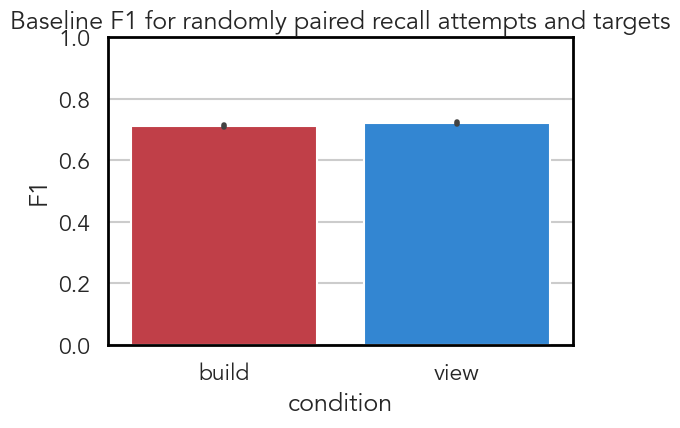

In [139]:
# fig = plt.figure(figsize=(6,6))
fig = plt.figure()

sns.barplot(data = df_baseline_f1,
                y = "F1",
                x = "condition",
                palette = palette)

plt.title("Baseline F1 for randomly paired recall attempts and targets")

for spine in fig.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
    spine.set_zorder(1)
    
plt.ylim((0,1))

plt.legend([],[], frameon=False)

In [140]:
# each ppt is associated with a range of F1s

assignments_dict[gameID][3]['assignment']

{6: 'talls_097_100',
 2: 'talls_100_097',
 5: 'talls_101_111',
 3: 'talls_102_126',
 1: 'talls_118_121',
 4: 'talls_121_101'}

## Build sequences

In addition to holistic measures like build time and accuracy, we can also look at the specific actions people take to see how building procedures varied across matched conditions.

In particular, we can compare how similar the reconstruction procedure is to:  
a) *their own* building procedure for the same tower in the recall phase (if it was a build match)
b) the average building procedure for the same tower in the recall phase

We can compare (a) and (b) for build matches. This will tell us whether people are build more similarly to how they encode the object than by chance, i.e. whether a part of what they are recalling is their building sequence.  
We can compare (b) for build and view matches. This will tell us whether people use more idiosyncratic strategies during recall than encoding/ whether people build differently when recalling vs. copying.

Here is one way of calculating distance between procedures.
1. map actions i
2. take some distance measure between them (e.g. Euclidean)
3. take the average

##### Notes
In a previous project, we found all action-action mappings and take the one that minimizes this distance. However I think that most stimuli can be made in exactly one way i.e. position of blocks is determined, so order is all that matters. This would mean that all sequences end up the same if shuffled.

Should we find variance in build procedures for each stimulus to get a sense of how varied they procedures for each one are? Some might be more memorable.

When someone recalls one of the build stimuli, is the procedure they use more similar to the way *they* built it previously (during "encoding") than to a random other participants' procedure when they encoded it?

#### Construct dataframe of recall phase build sequences

In [598]:
df_tmp = df_recalled_towers_unique[['gameID','nTower','tower_details','bestMatchCondition','bestMatch','bestMatchF1',]]\
.sort_values(['gameID','nTower'], ascending=[True, True]).reset_index(drop=True)

df_tmp.loc[:,'blocks'] = df_tmp['tower_details'].apply(lambda x: x['blocks'])

In [599]:
# Initialize an empty DataFrame to store the results
df_recall_blocks = pd.DataFrame()

# Iterate over each row in the original DataFrame
for index, row in df_tmp.iterrows():
    list_values = row['blocks']
    
    # Iterate over each element in the list (with its index)
    for element_index, element_value in enumerate(list_values):
        
        # Create a new row that includes the element and its index
        new_row = row.copy()
        new_row['block'] = element_value
        new_row['block_index'] = element_index
        new_row['x'] = new_row['block']['x']
        new_row['y'] = new_row['block']['y']
        new_row['width'] = new_row['block']['width']
        new_row['height'] = new_row['block']['height']
        
        # Append the new row to the results DataFrame
        df_recall_blocks = pd.concat([df_recall_blocks, pd.DataFrame([new_row])], ignore_index=True)

#### Construct dataframe of learn phase build sequences

In [600]:
df_learn_build = df_learn[df_learn.condition=='build'][['gameID','tower_id','rep','trial_index','blocks']]\
                    .sort_values(['gameID','trial_index'], ascending=[True, True]).reset_index(drop=True)

In [601]:
df_learn_build.loc[:,'blocks'] = df_learn_build['blocks'].apply(ast.literal_eval)

In [602]:
# Initialize an empty DataFrame to store the results
df_learn_blocks = pd.DataFrame()

# Iterate over each row in the original DataFrame
for index, row in df_learn_build.iterrows():
    list_values = row['blocks']
    
    # Iterate over each element in the list (with its index)
    for element_index, element_value in enumerate(list_values):
        
        # Create a new row that includes the element and its index
        new_row = row.copy()
        new_row['block'] = element_value
        new_row['block_index'] = element_index
        new_row['x'] = new_row['block']['x']
        new_row['y'] = new_row['block']['y']
        new_row['width'] = new_row['block']['width']
        new_row['height'] = new_row['block']['height']
        
        # Append the new row to the results DataFrame
        df_learn_blocks = pd.concat([df_learn_blocks, pd.DataFrame([new_row])], ignore_index=True)

In [603]:
# simplification for now: just look at the second rep

In [604]:
df_learn_blocks_r2 = df_learn_blocks[df_learn_blocks.rep > 1].reset_index(drop=True)

In [605]:
df_learn_blocks_r2

,gameID,tower_id,rep,trial_index,blocks,block,block_index,x,y,width,height
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,talls_114_111,2.0,9,"[{'x': 7, 'y': 0, 'width': 2, 'height': 1}, {'...","{'x': 7, 'y': 0, 'width': 2, 'height': 1}",0,7,0,2,1
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,talls_114_111,2.0,9,"[{'x': 7, 'y': 0, 'width': 2, 'height': 1}, {'...","{'x': 5, 'y': 0, 'width': 2, 'height': 1}",1,5,0,2,1
2,0403-00b72085-5f9c-4337-bec4-04dd488251fa,talls_114_111,2.0,9,"[{'x': 7, 'y': 0, 'width': 2, 'height': 1}, {'...","{'x': 5, 'y': 1, 'width': 1, 'height': 2}",2,5,1,1,2
3,0403-00b72085-5f9c-4337-bec4-04dd488251fa,talls_114_111,2.0,9,"[{'x': 7, 'y': 0, 'width': 2, 'height': 1}, {'...","{'x': 8, 'y': 1, 'width': 1, 'height': 2}",3,8,1,1,2
4,0403-00b72085-5f9c-4337-bec4-04dd488251fa,talls_114_111,2.0,9,"[{'x': 7, 'y': 0, 'width': 2, 'height': 1}, {'...","{'x': 7, 'y': 3, 'width': 2, 'height': 1}",4,7,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...
1195,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,talls_101_111,2.0,14,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","{'x': 5, 'y': 0, 'width': 2, 'height': 1}",3,5,0,2,1
1196,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,talls_101_111,2.0,14,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","{'x': 6, 'y': 1, 'width': 1, 'height': 2}",4,6,1,1,2
1197,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,talls_101_111,2.0,14,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","{'x': 5, 'y': 3, 'width': 2, 'height': 1}",5,5,3,2,1
1198,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,talls_101_111,2.0,14,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","{'x': 4, 'y': 4, 'width': 1, 'height': 2}",6,4,4,1,2


#### Calculate distances between sequences

measure: pair up build matches (recall towers matched with a built stimulus) with the reconstruction.
calculate these distances (by gameid, towerid).

baseline: pair up build matches (recall towers matched with a built stimulus) with a random other participants' reconstruction (by tower id).

In [606]:
from scipy.spatial import distance

def find_learn_sequence(row, df, random_matching_seq=False):
    '''
    find building sequence in learning df
    '''
    if not random_matching_seq:
        seq = df[(df.tower_id == row.bestMatch) & (df.gameID == row.gameID)].reset_index(drop=True)
        if len(seq) != 8:
            print(seq)
            print(row.bestMatch)
            print(row.bestMatch)
        return seq
    
    else:
        all_matching_towers = df[(df.tower_id == row.bestMatch) & (df.gameID != row.gameID)].reset_index(drop=True)
        all_matching_towers_grouped = all_matching_towers.groupby('gameID')
        random_group_key = random.choice(list(all_matching_towers_grouped.groups.keys()))
        random_group = all_matching_towers_grouped.get_group(random_group_key)
        
        return(random_group)

def mean_euclidean(seq_a, seq_b):
    a = seq_a[['x','y','width','height']]
    b = seq_b[['x','y','width','height']]
    ds = [distance.euclidean(a.iloc[i,:], 
                             b.iloc[i,:]) for i in range(len(seq_a))]
    d = np.mean(ds)
    return d

def calculate_scores(seq_a, distance = mean_euclidean, random_matching_seq = False):
    '''
    Grabs building sequences of matched build stimulus,
    then calculates distance between sequences
    '''
    seq_b = find_learn_sequence(seq_a.iloc[0], df_learn_blocks_r2, random_matching_seq = random_matching_seq)
    d = distance(seq_a, seq_b)
    return d

In [607]:
# calculate actual distances between construction procedures in learning phase (rep 2 of 2)
# and recall phase (build matches only)

df_build_dists = df_recall_blocks.query('bestMatchCondition == "build"')\
                    .groupby(['gameID','nTower','bestMatch'])\
                    .apply(calculate_scores).reset_index().rename(columns={0:'distance'})

df_build_dists

,gameID,nTower,bestMatch,distance
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,1,talls_114_111,2.000000
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,2,talls_100_097,1.750000
2,0403-00b72085-5f9c-4337-bec4-04dd488251fa,4,talls_118_121,1.183013
3,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,2,talls_114_111,1.250000
4,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,3,talls_097_118,2.662455
...,...,...,...,...
100,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,1,talls_097_100,1.942079
101,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,2,talls_111_127,1.891979
102,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,3,talls_118_114,1.484789
103,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,2,talls_097_118,2.131495


In [608]:
# example of calculating baseline distance between construction procedure in recall phase (build matches only)
# and randomly paired procedure in learning phase (rep 2 of 2) 

df_build_dists_random = df_recall_blocks.query('bestMatchCondition == "build"')\
                    .groupby(['gameID','nTower','bestMatch'])\
                    .apply(lambda x: calculate_scores(x, random_matching_seq = True))\
                    .reset_index().rename(columns={0:'distance'})

df_build_dists_random

,gameID,nTower,bestMatch,distance
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,1,talls_114_111,1.250000
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,2,talls_100_097,1.000000
2,0403-00b72085-5f9c-4337-bec4-04dd488251fa,4,talls_118_121,1.183013
3,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,2,talls_114_111,0.000000
4,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,3,talls_097_118,2.244611
...,...,...,...,...
100,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,1,talls_097_100,2.249087
101,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,2,talls_111_127,1.976459
102,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,3,talls_118_114,1.449469
103,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,2,talls_097_118,2.135751


In [609]:
# bootstrap a distribution of distances
# consider other ways of aggregating (by ppt or tower or ntower?)

n_iter = 1000

df_build_dists_baseline_means = [] # mean for iteration (across all towers)

df_build_dists_baseline_all = pd.DataFrame()

for i in range(n_iter):
    df_build_dists_baseline = df_recall_blocks.query('bestMatchCondition == "build"')\
                    .groupby(['gameID','nTower','bestMatch'])\
                    .apply(lambda x: calculate_scores(x, random_matching_seq = True))\
                    .reset_index().rename(columns={0:'distance'})
    
    df_build_dists_baseline.loc[:,'iter'] = i
    
    df_build_dists_baseline_all = pd.concat([df_build_dists_baseline_all, df_build_dists_baseline], ignore_index=True)
    
    df_build_dists_baseline_means.append(df_build_dists_baseline.distance.mean())

In [610]:
df_build_dists_baseline_all

,gameID,nTower,bestMatch,distance,iter
0,0403-00b72085-5f9c-4337-bec4-04dd488251fa,1,talls_114_111,1.250000,0
1,0403-00b72085-5f9c-4337-bec4-04dd488251fa,2,talls_100_097,1.750000,0
2,0403-00b72085-5f9c-4337-bec4-04dd488251fa,4,talls_118_121,1.183013,0
3,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,2,talls_114_111,0.750000,0
4,0559-000a48f8-3af5-4489-a83b-7158b6fc5fb9,3,talls_097_118,2.763105,0
...,...,...,...,...,...
104995,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,1,talls_097_100,1.633062,999
104996,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,2,talls_111_127,1.671063,999
104997,9537-a4cb8e30-2593-4f24-a368-351cffbe1004,3,talls_118_114,1.262471,999
104998,9894-b0bd18cd-ad29-426a-ba20-1c769711d5a6,2,talls_097_118,2.131495,999


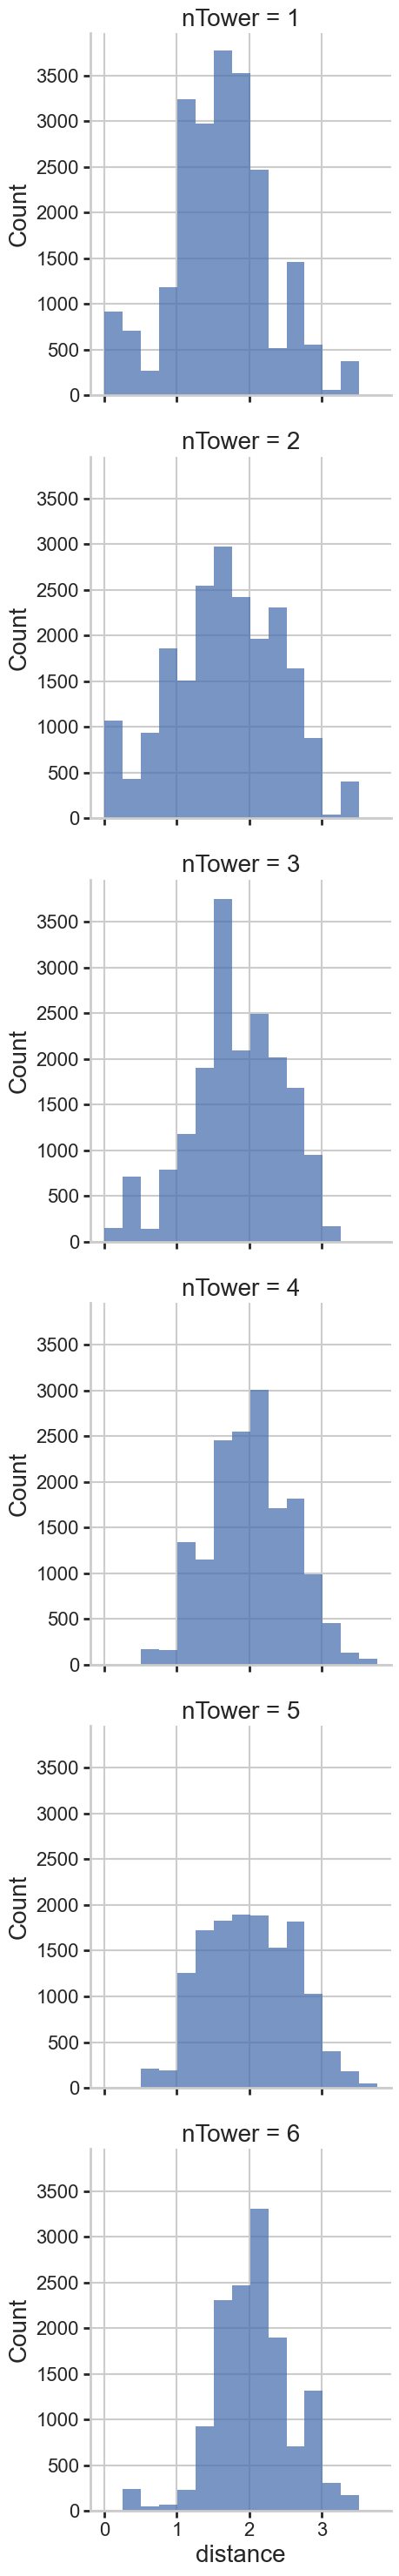

In [611]:
sns.displot(df_build_dists_baseline_all, kind='hist', x='distance', row='nTower', bins=15)

In [612]:
np.mean(df_build_dists[df_build_dists.nTower == nTower].distance.mean() < df_build_dists_baseline_all[df_build_dists_baseline_all.nTower == nTower].groupby('iter').distance.mean())

0.598

In [613]:
for nTower in range(1,7):
    actual = df_build_dists[df_build_dists.nTower == nTower].distance.mean()
    baseline = df_build_dists_baseline_all[df_build_dists_baseline_all.nTower == nTower].groupby('iter').distance.mean()

In [614]:
for nTower in range(1,7):
    actual = df_build_dists[df_build_dists.nTower == nTower].distance.mean()
    baseline = df_build_dists_baseline_all[df_build_dists_baseline_all.nTower == nTower].groupby('iter').distance.mean()
    print(np.mean(actual > baseline))

0.0
0.144
0.199
0.022
0.0
0.402


In [615]:
np.sum(df_build_dists[df_build_dists.nTower == 0+1].distance.mean() < df_build_dists_baseline_all[df_build_dists_baseline_all.nTower == 1].groupby('iter').distance.mean())

1000

In [616]:
len(df_build_dists_baseline_means)

1000

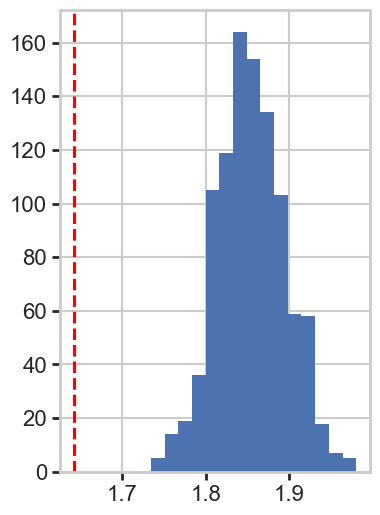

In [617]:
# across all recall towers (1-6)
plt.hist(df_build_dists_baseline_means,bins=15)
plt.axvline(x=df_build_dists.distance.mean(), color='red', linestyle='--', label='Vertical Line')

In [618]:
overall_pval = np.sum(df_build_dists_baseline_means < df_build_dists.distance.mean())/n_iter
print("p = " + str(overall_pval))

p = 0.0


##### By number tower (i.e. first tower recalled to last tower recalled)

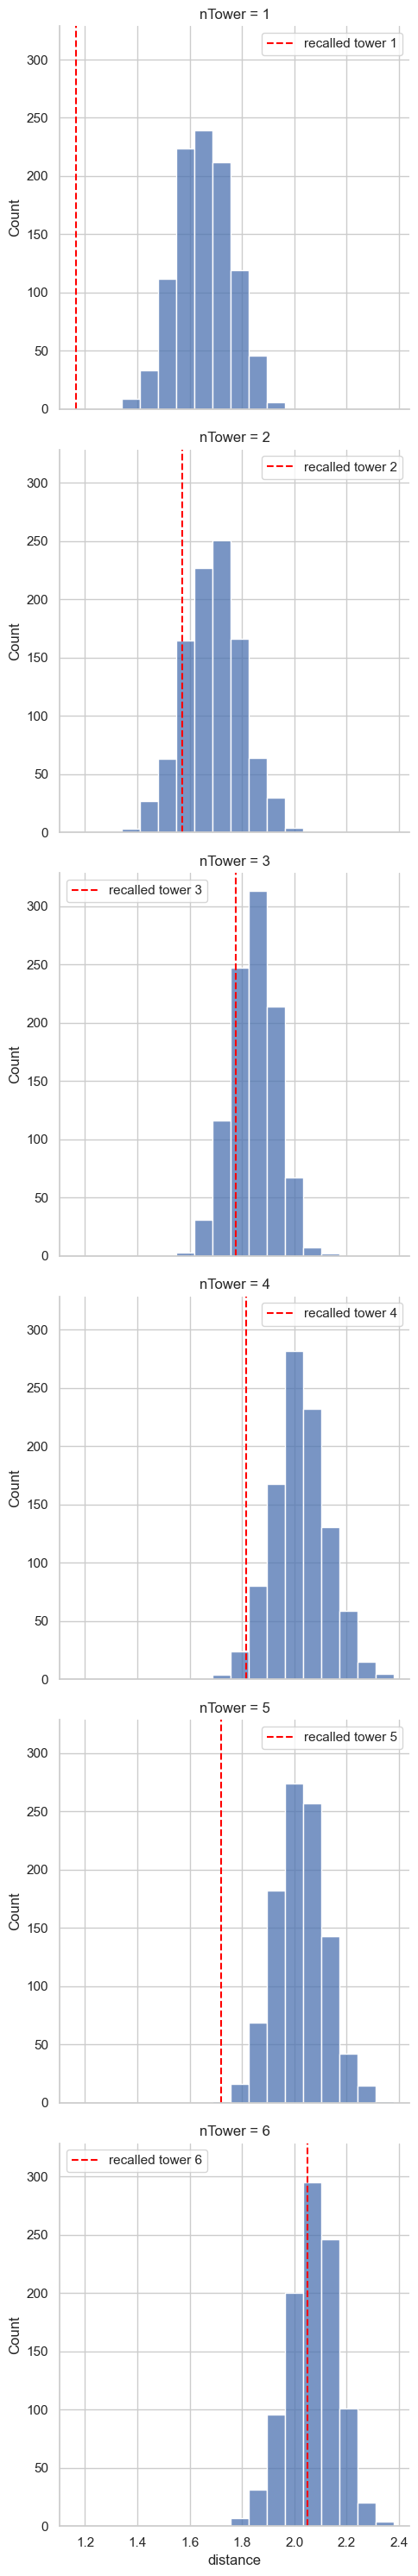

In [619]:
# Create a sample Seaborn catplot with facets
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
# g = sns.displot(data=df_build_dists_baseline_all, x="distance", row="nTower", kind="hist", bins=15)

mean_distances_by_iter = df_build_dists_baseline_all.groupby(["iter",'nTower'])["distance"].mean().reset_index()
# Create a displot with the mean distances
g = sns.displot(data=mean_distances_by_iter, x="distance", bins=15, row="nTower", kind="hist")

# List of x-values for the vertical lines (one for each column)
x_values = [1, 2, 3, 4]  # Adjust values as needed

# Loop through each facet's axis and add vertical lines
for row, ax in enumerate(g.axes.flat):
    stat = df_build_dists[df_build_dists.nTower == row+1].distance.mean()
    ax.axvline(x=stat, color='red', linestyle='--', label=f'recalled tower {row+1}')
    ax.legend()

# Show the plot
plt.show()

#### temporal dynamics

How do recalled towers change over time? Participants were permitted to submit up to 6 towers, but submitting 6 does not necessarily mean they remembered them.

Text(0.5, 1.0, 'Average F1 score in order recalled')

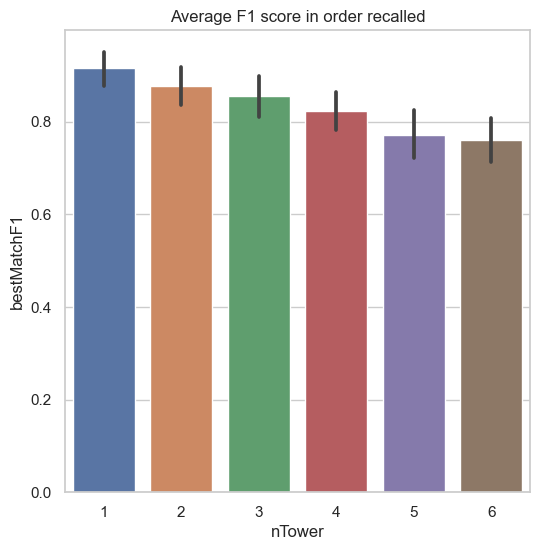

In [620]:
# accuracy drops off over time

fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recalled_towers_unique, 
            y = "bestMatchF1", 
            x = "nTower")

plt.title('Average F1 score in order recalled')

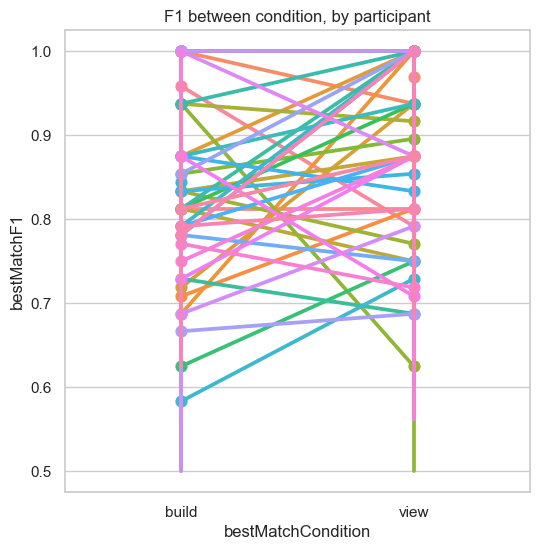

In [621]:
# diff between F1 condition, calculated from recalled towers

fig = plt.figure(figsize=(6,6))

sns.pointplot(data = df_recalled_towers_unique,
                y = "bestMatchF1",
                x = "bestMatchCondition",
                hue = "gameID",
                order=["build","view"])

plt.title('F1 between condition, by participant')

plt.legend([],[], frameon=False)

#### recency bias?

In [622]:
df_learn_rep_2 = df_learn[df_learn.rep==2].reset_index(drop=True)
df_learn_rep_2.columns

Index(['Unnamed: 0', '_id', 'trial_start_time', 'trial_finish_time',
       'condition', 'stimulus', 'response', 'trial_num', 'block_str',
       'tower_id', 'tower_A_tall_id', 'tower_A_wide_id', 'tower_B_tall_id',
       'tower_B_wide_id', 'tower_id_tall', 'composite_id', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'experimentName',
       'iterationName', 'workerID', 'gameID', 'studyLocation', 'datatype',
       'timeAbsolute', 'timeRelative', 'blocks', 'discreteWorld', 'eventType',
       'endReason', 'relative_time', 'rep', 'n_resets', 'stim_wide',
       'square_map', 'alignedBlockMaps', 'alignedBlockMapsHashable',
       'paddedBlockMaps'],
      dtype='object')

In [625]:
df_learn_rep_2.trial_num.unique()

array([ 7,  8,  9, 10, 11, 12])

In [626]:
df_learn_rep_2['last_exposure'] = df_learn_rep_2.trial_num - 12

In [ ]:
# look at each reconstruction, see when it was last displayed

In [630]:
def find_last_exposure(row, df = df_learn_rep_2):
    subset = df[(df.gameID==row.gameID) & (df.tower_id==row.bestMatch)]
    assert (len(subset)==1)
    return subset.iloc[0]['last_exposure'] 
    

In [632]:
df_recalled_towers_unique['last_exposure'] = df_recalled_towers_unique.apply(find_last_exposure, axis=1)

Text(0.5, 1.0, 'Accuracy by how long ago stimulus was viewed')

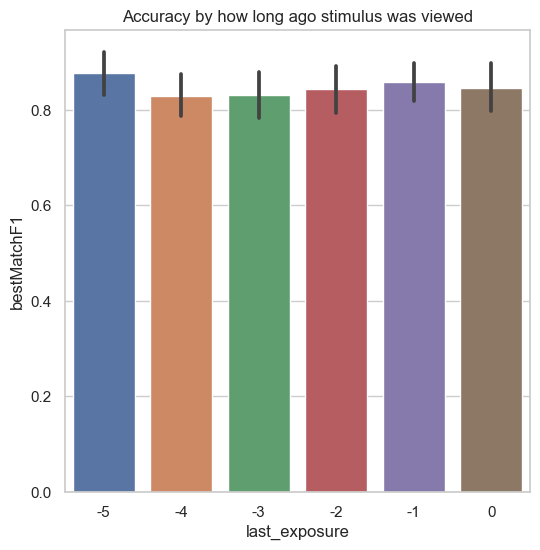

In [634]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recalled_towers_unique, 
            y = "bestMatchF1", 
            x = "last_exposure")

plt.title('Accuracy by how long ago stimulus was viewed')

Text(0.5, 1.0, 'Accuracy by how long ago stimulus was viewed')

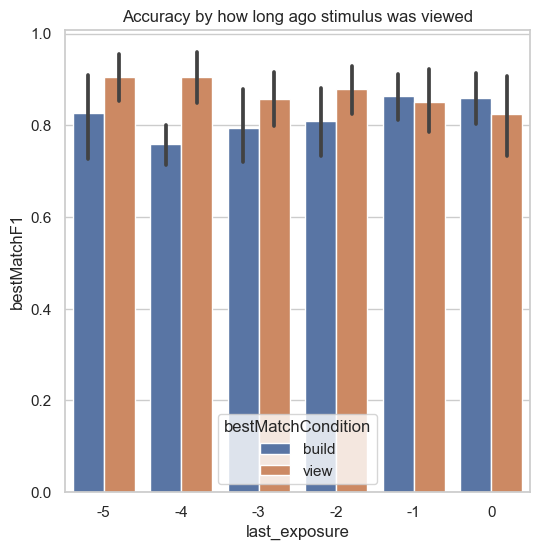

In [636]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recalled_towers_unique, 
            y = "bestMatchF1", 
            x = "last_exposure",
            hue = "bestMatchCondition")

plt.title('Accuracy by how long ago stimulus was viewed')

In [142]:
df_learn_towers_f1 = \
df_learn_rep_1[df_learn_rep_1.matched_recall]\
    .merge(df_recalled_towers_unique[['gameID','bestMatchF1','bestMatch']], left_on=['gameID','tower_id'], 
           right_on=['gameID','bestMatch'])


AttributeError: 'DataFrame' object has no attribute 'matched_recall'

In [270]:
# diff between F1 condition,

fig = plt.figure(figsize=(6,6))

sns.pointplot(data = df_learn_towers_f1,
                y = "bestMatchF1",
                x = "condition",
                hue = "gameID",
                order=["build","view"])

plt.title('F1 between condition, by participant')

plt.legend([],[], frameon=False)

NameError: name 'df_learn_towers_f1' is not defined

<Figure size 600x600 with 0 Axes>

In [271]:
# diff between F1 condition,

fig = plt.figure(figsize=(6,6))

sns.pointplot(data = df_learn_towers_f1,
                y = "bestMatchF1",
                x = "condition",
                hue = "tower_id",
                order=["build","view"])

plt.title('F1 between condition, by participant')

plt.legend([],[], frameon=False)

NameError: name 'df_learn_towers_f1' is not defined

<Figure size 600x600 with 0 Axes>

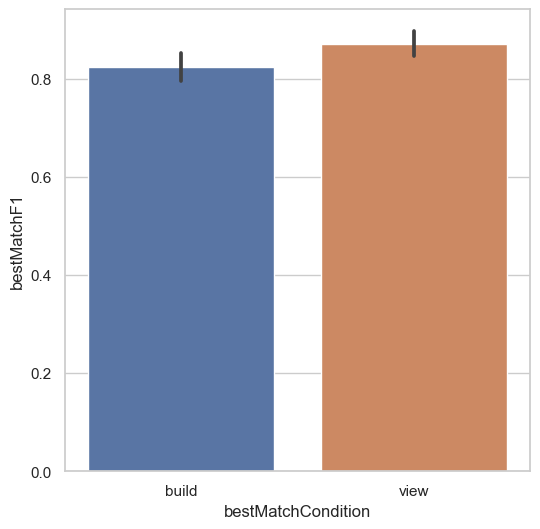

In [272]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recalled_towers_unique,
                y = "bestMatchF1",
                x = "bestMatchCondition")

plt.legend([],[], frameon=False)

<Figure size 600x600 with 0 Axes>

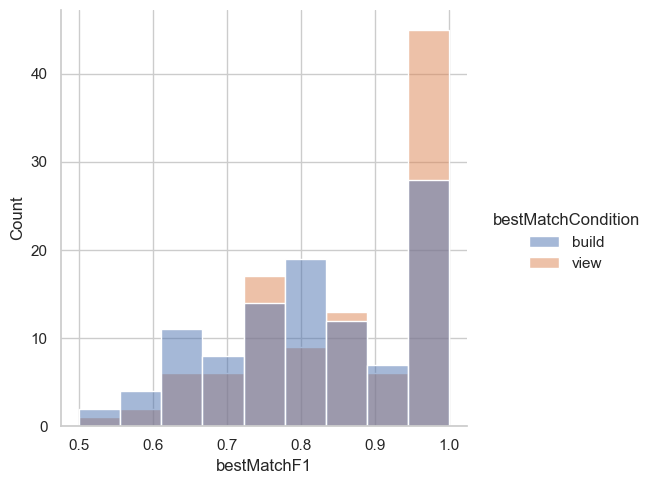

In [273]:
fig = plt.figure(figsize=(6,6))

sns.displot(data = df_recalled_towers_unique, 
            x = "bestMatchF1", 
            hue = "bestMatchCondition")

#### By stimulus

stimuli randomized ie. **not counterbalanced** between groups

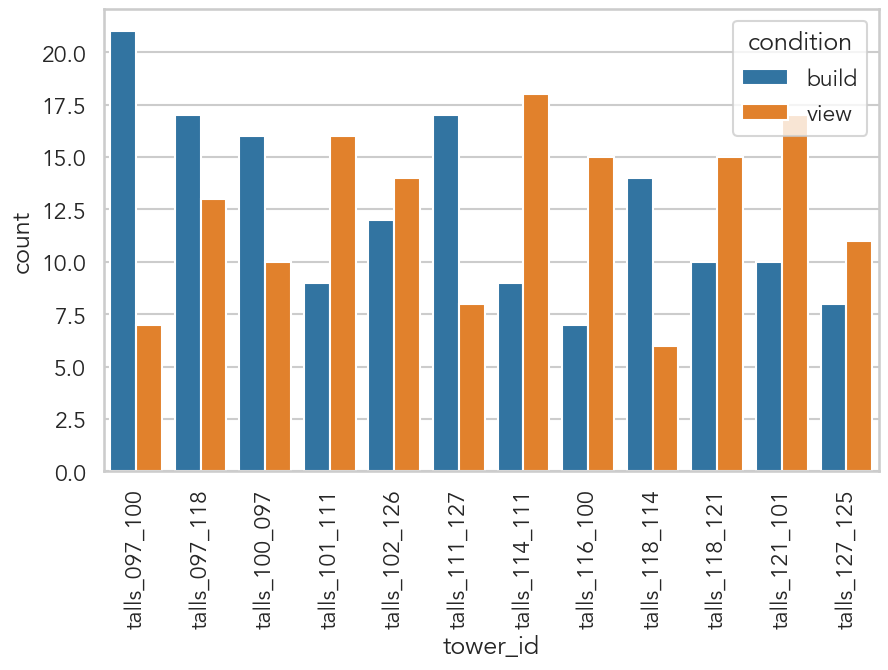

In [155]:
# stimuli are not particularly balanced between condition(!)
fig = plt.figure(figsize=(10,6))
sns.countplot(data = df_learn[df_learn.rep==1],
            x = 'tower_id',
            order = np.sort(df_learn.tower_id.unique()),
            hue_order = ["build","view"],
            hue = 'condition')
_ = plt.xticks(rotation = 90)

In [38]:
gameIDs = df_learn.gameID.unique()

In [39]:
# for each learned stim, count how many times it was matched

In [143]:
df_learn['matched_recall'] = False

for gameID in gameIDs:
    df_learn_ppt = df_learn.query('gameID == @gameID')
    
    for (i, row) in df_learn_ppt.iterrows():
        stimID = row['tower_id']
        df_learn.loc[i,'matched_recall'] = len(df_recalled_towers_unique.query('(gameID == @gameID) & (bestMatch == @stimID)')) > 0


In [144]:
df_learn_rep_1 = df_learn.sort_values('trial_start_time').groupby(['gameID','tower_id']).first().reset_index()

In [145]:
df_learn_rep_1.groupby(['tower_id','condition']).count()

gameID  Unnamed: 0  _id  trial_start_time   
tower_id      condition                                              
talls_097_100 build          21          21   21                21  \
              view            7           7    7                 7   
talls_097_118 build          17          17   17                17   
              view           13          13   13                13   
talls_100_097 build          16          16   16                16   
              view           10          10   10                10   
talls_101_111 build           9           9    9                 9   
              view           16          16   16                16   
talls_102_126 build          12          12   12                12   
              view           14          14   14                14   
talls_111_127 build          17          17   17                17   
              view            8           8    8                 8   
talls_114_111 build           9           9    9                 9   
              view           18          18   18                18   
talls_116_100 build           7           7    7                 7   
              view           15          15   15                15   
talls_118_114 build          14          14   14                14   
              view            6           6    6                 6   
talls_118_121 build          10          10   10                10   
              view           15          15   15                15   
talls_121_101 build          10          10   10                10   
              view           17          17   17                17   
talls_127_125 build           8           8    8                 8   
              view           11          11   11                11   

                         trial_finish_time  stimulus  response  trial_num   
tower_id      condition                                                     
talls_097_100 build                      0        21         0         21  \
              view                       7         7         0          7   
talls_097_118 build                      0        17         0         17   
              view                      13        13         0         13   
talls_100_097 build                      0        16         0         16   
              view                      10        10         0         10   
talls_101_111 build                      0         9         0          9   
              view                      16        16         0         16   
talls_102_126 build                      0        12         0         12   
              view                      14        14         0         14   
talls_111_127 build                      0        17         0         17   
              view                       8         8         0          8   
talls_114_111 build                      0         9         0          9   
              view                      18        18         0         18   
talls_116_100 build                      0         7         0          7   
              view                      15        15         0         15   
talls_118_114 build                      0        14         0         14   
              view                       6         6         0          6   
talls_118_121 build                      0        10         0         10   
              view                      15        15         0         15   
talls_121_101 build                      0        10         0         10   
              view                      17        17         0         17   
talls_127_125 build                      0         8         0          8   
              view                      11        11         0         11   

                         block_str  tower_A_tall_id  ...  endReason   
tower_id      condition                              ...              
talls_097_100 build             21               21  ...   

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'talls_097_100'),
  Text(1, 0, 'talls_100_097'),
  Text(2, 0, 'talls_102_126'),
  Text(3, 0, 'talls_114_111'),
  Text(4, 0, 'talls_118_121'),
  Text(5, 0, 'talls_127_125'),
  Text(6, 0, 'talls_097_118'),
  Text(7, 0, 'talls_101_111'),
  Text(8, 0, 'talls_116_100'),
  Text(9, 0, 'talls_121_101'),
  Text(10, 0, 'talls_111_127'),
  Text(11, 0, 'talls_118_114')])

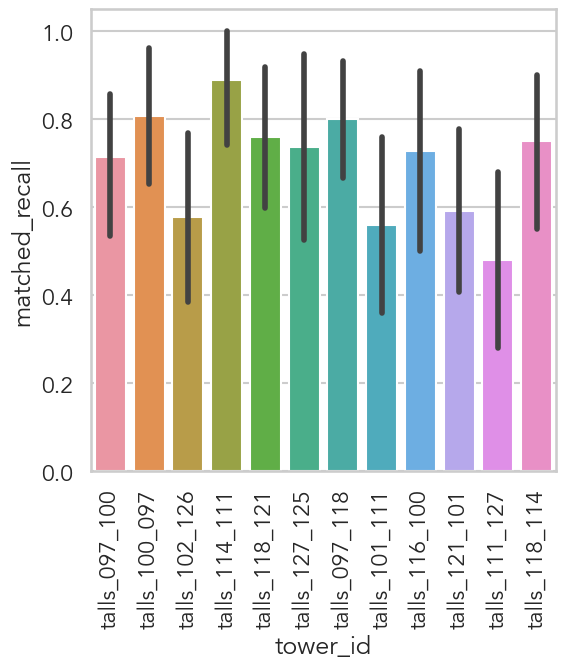

In [146]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_learn_rep_1, 
            y = "matched_recall",
            x = "tower_id")

plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'talls_097_100'),
  Text(1, 0, 'talls_097_118'),
  Text(2, 0, 'talls_100_097'),
  Text(3, 0, 'talls_101_111'),
  Text(4, 0, 'talls_102_126'),
  Text(5, 0, 'talls_111_127'),
  Text(6, 0, 'talls_114_111'),
  Text(7, 0, 'talls_116_100'),
  Text(8, 0, 'talls_118_114'),
  Text(9, 0, 'talls_118_121'),
  Text(10, 0, 'talls_121_101'),
  Text(11, 0, 'talls_127_125')])

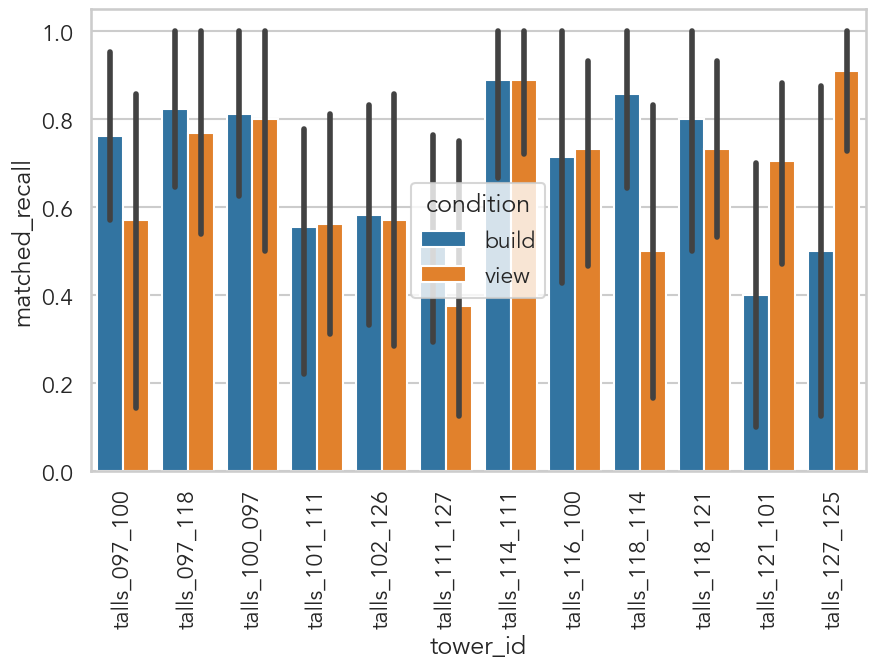

In [148]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data = df_learn_rep_1, 
            y = "matched_recall",
            hue = "condition",
            hue_order = ["build","view"],
            x = "tower_id",
            order = np.sort(df_learn.tower_id.unique()))

plt.xticks(rotation = 90)

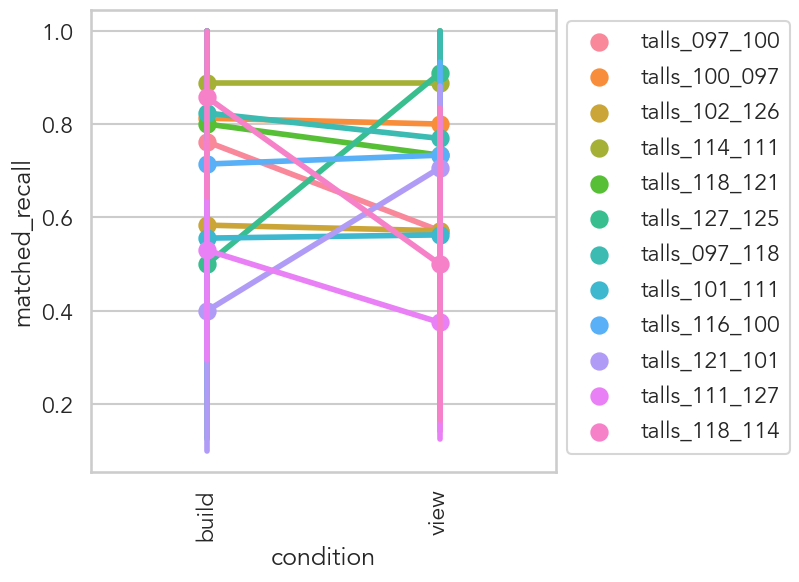

In [149]:
fig = plt.figure(figsize=(6,6))

sns.pointplot(data = df_learn_rep_1, 
            y = "matched_recall",
            x = "condition",
            hue = "tower_id",
            order=["build","view"])

plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1,1))

In [150]:
test_stim_gameIDs = list(df_learn_rep_1[df_learn_rep_1.tower_id == 'talls_097_100']['gameID'])

0403-00b72085-5f9c-4337-bec4-04dd488251fa
0837-7dc8f2c1-c6df-400c-ae2f-2174ffd0ffb1
2149-9f29790e-0346-41b9-923e-0fe3ab918514
2292-aca8604c-6823-4b21-9d62-05456ee994c9
2465-1f63d92b-725b-4851-b910-9b71e1731fff
3493-b9f1d2a9-0a74-44bf-abf4-4d3e55e9f9cd
4207-a4d9145c-c5c1-42c6-9c1b-919ae2ca2e26
5494-bb8b8dc6-841d-48dc-b262-f28c7a342bce
5533-012c1356-92a6-4a60-bd4e-8ff5a33aa8f6
5955-c71bea47-b459-49a5-b5a9-69ce06110ee0
7004-4417afd1-9081-42a3-b653-9cf279904cb5
7596-b4b1af8a-ae20-4a8e-a9c8-399036693648
7773-1b67ae19-c0ba-4173-916f-6905b72c894c
8269-6b7d581c-d5ac-4d0d-a48d-db6da4e40ccf
8430-1b1d568f-f51e-44e7-bb75-f7629d3a44ed
8606-acc7425f-fe32-4cec-a98b-d094e900142e
8685-2b9de59d-e1a1-44b2-9ab0-63ae52599be7
9009-d9ea75a9-7210-4d13-b88b-45f9ce36b9be
9122-98410562-bea6-46af-8e2b-e03cd2cea96b
9537-a4cb8e30-2593-4f24-a368-351cffbe1004


""


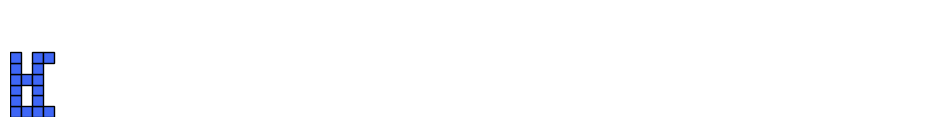

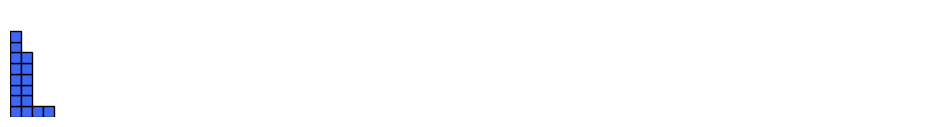

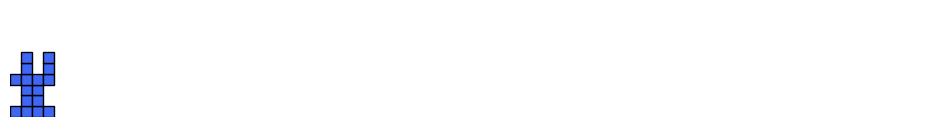

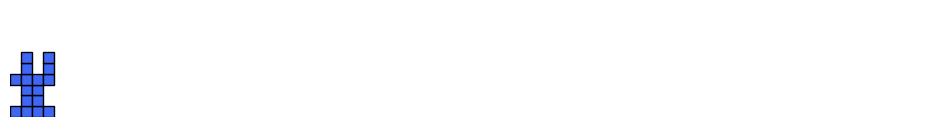

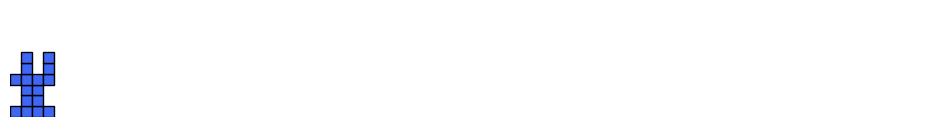

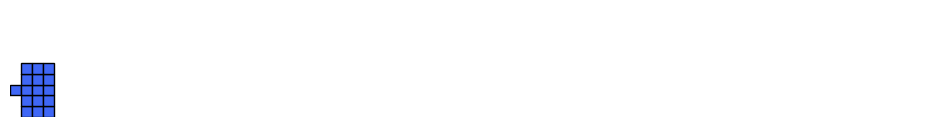

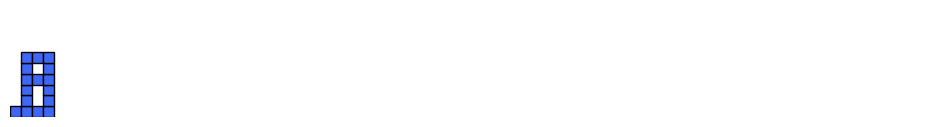

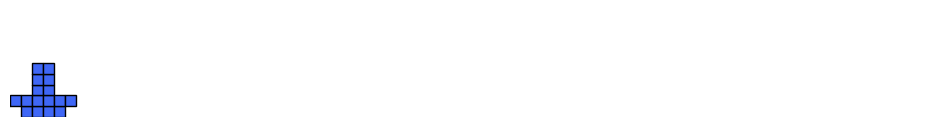

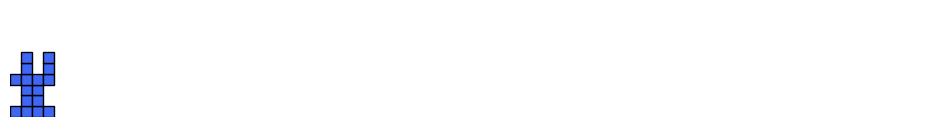

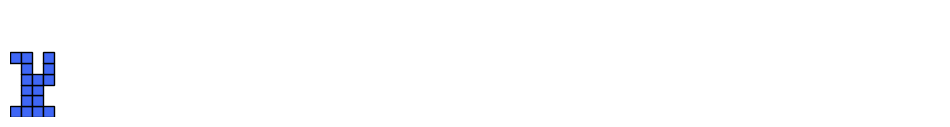

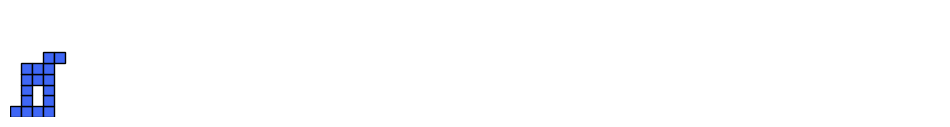

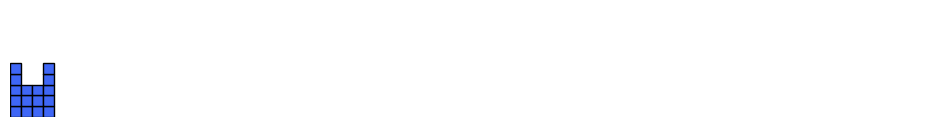

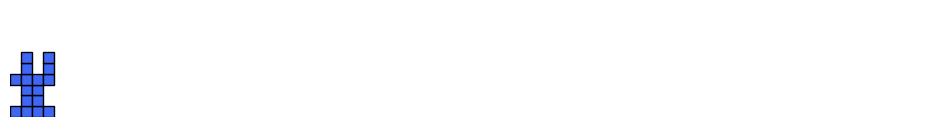

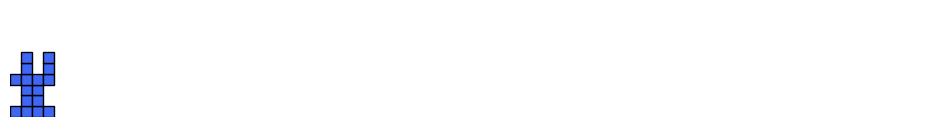

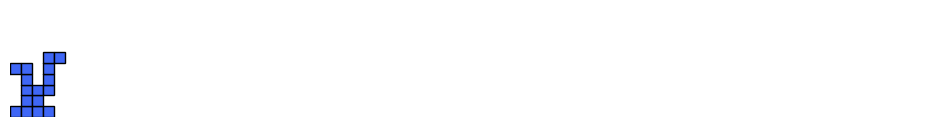

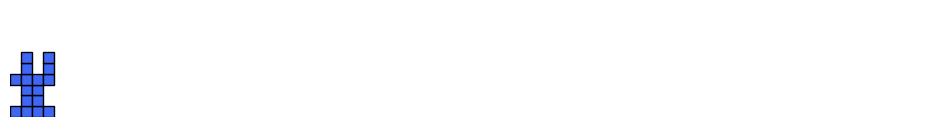

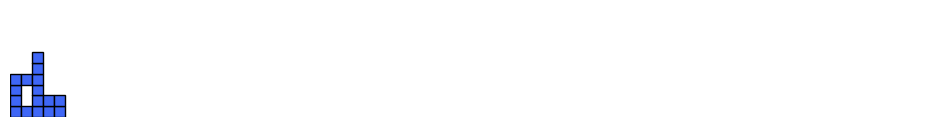

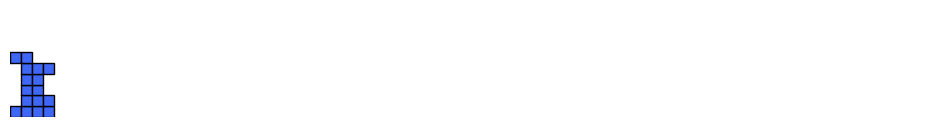

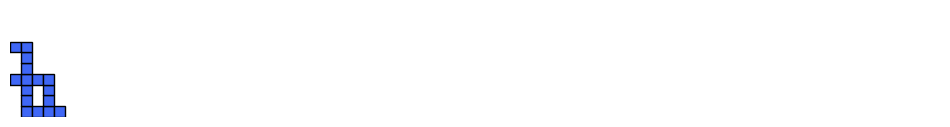

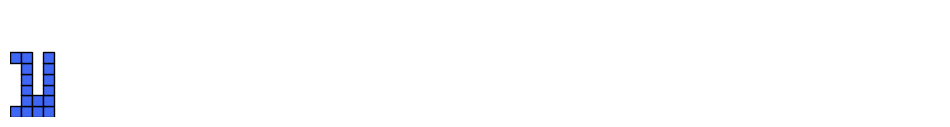

In [151]:
# render everyone's recalled towers
df_recalled_towers_unique[(df_recalled_towers_unique.gameID.isin(test_stim_gameIDs)) & \
                  (df_recalled_towers_unique.bestMatch=='talls_097_100') \
                  ].groupby('gameID').apply(show_recalled_towers)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'talls_100_097'),
  Text(1, 0, 'talls_114_111'),
  Text(2, 0, 'talls_097_100'),
  Text(3, 0, 'talls_118_121'),
  Text(4, 0, 'talls_102_126'),
  Text(5, 0, 'talls_127_125'),
  Text(6, 0, 'talls_097_118'),
  Text(7, 0, 'talls_121_101'),
  Text(8, 0, 'talls_116_100'),
  Text(9, 0, 'talls_101_111'),
  Text(10, 0, 'talls_118_114'),
  Text(11, 0, 'talls_111_127')])

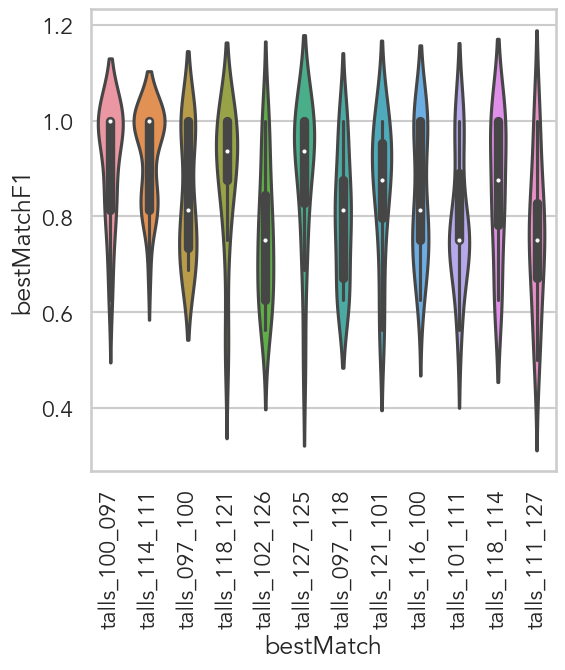

In [152]:
fig = plt.figure(figsize=(6,6))

sns.violinplot(data = df_recalled_towers_unique, 
            y = "bestMatchF1", 
            x = "bestMatch",
            stat='count')

plt.xticks(rotation = 90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'talls_100_097'),
  Text(1, 0, 'talls_114_111'),
  Text(2, 0, 'talls_097_100'),
  Text(3, 0, 'talls_118_121'),
  Text(4, 0, 'talls_102_126'),
  Text(5, 0, 'talls_127_125'),
  Text(6, 0, 'talls_097_118'),
  Text(7, 0, 'talls_121_101'),
  Text(8, 0, 'talls_116_100'),
  Text(9, 0, 'talls_101_111'),
  Text(10, 0, 'talls_118_114'),
  Text(11, 0, 'talls_111_127')])

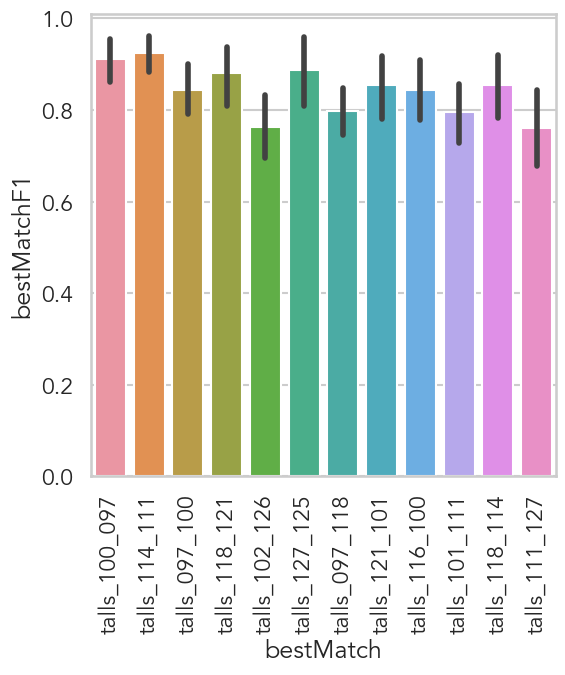

In [153]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recalled_towers_unique, 
            y = "bestMatchF1", 
            x = "bestMatch",
            order=tower_ids)

plt.xticks(rotation = 90)


In [647]:
tower_ids

array(['talls_100_097', 'talls_114_111', 'talls_097_100', 'talls_118_121',
       'talls_102_126', 'talls_127_125', 'talls_097_118', 'talls_121_101',
       'talls_116_100', 'talls_101_111', 'talls_118_114', 'talls_111_127'],
      dtype=object)

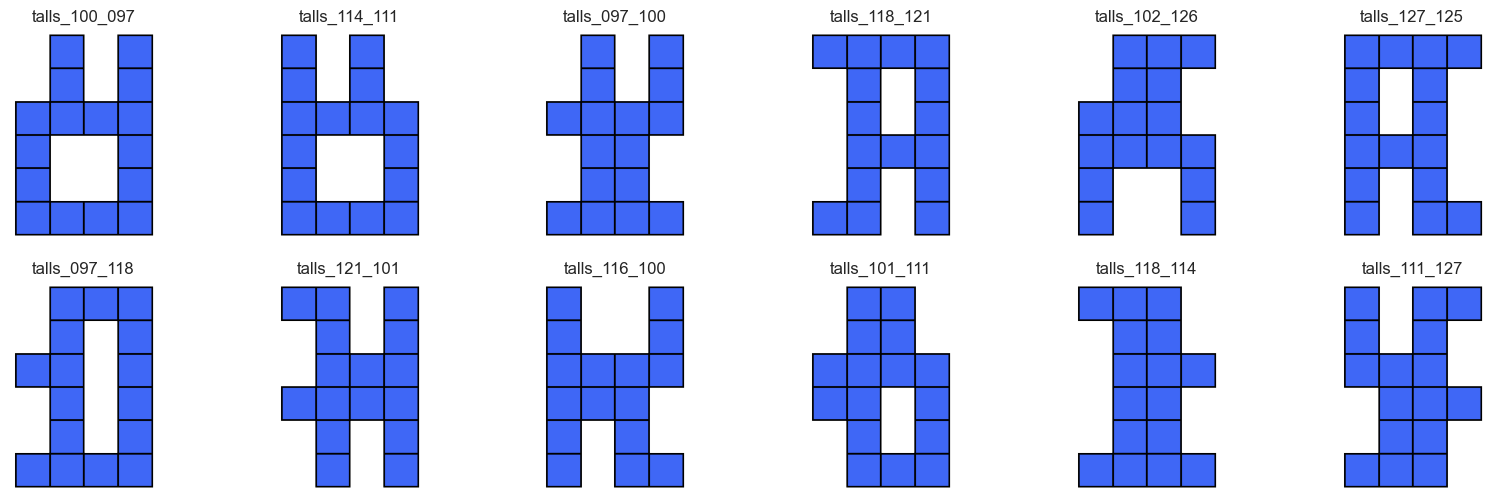

In [648]:
n_row = 2
fig, axs = plt.subplots(n_row, int(len(tower_ids)/n_row), figsize=(20,6))

for i, tower in enumerate(tower_ids):
    show_tower_subplot(tower, axs[int(np.floor(i/(len(tower_ids)/n_row))), i%(int(len(tower_ids)/n_row))])

In [649]:
f1_stim_avg = df_recalled_towers_unique.groupby(['bestMatch','bestMatchCondition'])['bestMatchF1'].mean().reset_index()
f1_stim_avg

,bestMatch,bestMatchCondition,bestMatchF1
0,talls_097_100,build,0.839844
1,talls_097_100,view,0.859375
2,talls_097_118,build,0.781250
3,talls_097_118,view,0.818750
4,talls_100_097,build,0.913462
5,talls_100_097,view,0.906250
6,talls_101_111,build,0.737500
7,talls_101_111,view,0.826389
8,talls_102_126,build,0.803571
9,talls_102_126,view,0.726562


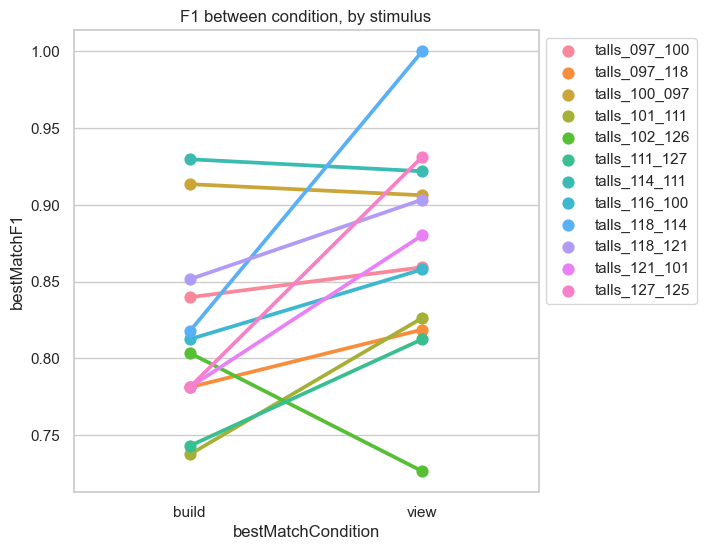

In [650]:
fig = plt.figure(figsize=(6,6))

sns.pointplot(data = f1_stim_avg,
                y = "bestMatchF1",
                x = "bestMatchCondition",
                hue = "bestMatch")

plt.title('F1 between condition, by stimulus')

plt.legend(bbox_to_anchor=(1,1))

# Old

## Building measures

#### Build time

relative_time: time between start and end of building trial. This includes *all* attempts, i.e. time including resets.

In [ ]:
df_build = df_encode[df_encode.trial_type == 'block-tower-building']

In [ ]:
build_times = df_build.groupby('gameID')[['relative_time']].mean().reset_index()

In [ ]:
plt.figure(figsize =(10,6))

sns.barplot(data = df_build,
            x = 'gameID',
            y = 'relative_time',
            )

In [ ]:
sns.histplot(build_times,
            x = 'relative_time',
            log_scale=False,
            bins=10)

In [ ]:
build_times.mean()

Average build time is a lot longer than the 15 seconds people have to view the structure. 

### Resets

In [ ]:
reset_means = df_build.groupby('gameID')[['n_resets']].mean().reset_index()

In [ ]:
# raw trials
sns.histplot(df_build,
            x = 'n_resets',
            log_scale=False,
            bins=10)

In [ ]:
# mean for ppts
sns.histplot(reset_means,
            x = 'n_resets',
            log_scale=False,
            bins=10)

## Time measures

These plots seem to suggest that the longer you wait between encoding and recall, the worse your memory of that item.

In [ ]:
# this dataframe contains recognition trials only from targets (i.e. non-foils)
# it is augmented with additional variables from here onwards
df_recog_target = df_recog[df_recog.condition != 'foil']

#### Encoding trial number

Were the targets that were viewed/ built later remembered better?
Looks like that may be the case.
Also looks like a slight primacy bias?

In [ ]:
df_encode['encode_trial_num'] = df_encode.trial_num

In [ ]:
df_recog_target = df_recog_target.merge(df_encode[df_encode.condition != 'foil']\
                                        [['gameID', 'tower_id','encode_trial_num']], 
                                        on = ['gameID','tower_id'])

In [ ]:
sns.lineplot(data = df_recog_target,
                x = 'encode_trial_num',
                y = 'response_correct')
plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Recog trial number

Were the targets that were probed earlier remembered better?

In [ ]:
df_recog['recog_trial_num'] = df_recog.trial_num - 12
df_recog_target['recog_trial_num'] = df_recog_target.trial_num - 12

In [ ]:
sns.lineplot(data = df_recog,
                x = 'recog_trial_num',
                y = 'response_correct')
plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Number of trials between encoding and recognition

Were the targets with a smaller gap (number of trials) between encoding and recognition better remembered?

Eyeballing this graph it does look like the longer between encoding and recognition trials, the worse the performance.

In [ ]:
def trial_diff(df, col='trial_num'):
    return df[col].max() - df[col].min()

In [ ]:
trial_diffs = df_trial[df_trial.condition != 'foil'].groupby(['gameID','tower_id']).apply(trial_diff).reset_index()

In [ ]:
trial_diffs = trial_diffs.rename(columns = {0: 'trial_diff'})

In [ ]:
df_recog_target = df_recog_target.merge(trial_diffs, on=['gameID','tower_id'])

In [ ]:
sns.lineplot(data = df_recog_target,
                x = 'trial_diff',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Duration between encoding and recognition

Were the targets with a smaller gap (absolute time) between encoding and recognition better remembered?

In [ ]:
trial_time_diffs = df_trial[df_trial.condition != 'foil']\
    .groupby(['gameID','tower_id']).apply(lambda group: trial_diff(group, col='trial_start_time')).reset_index()

In [ ]:
trial_time_diffs = trial_time_diffs.rename(columns = {0: 'trial_time_diff'})

In [ ]:
df_recog_target = df_recog_target.merge(trial_time_diffs, on=['gameID','tower_id'])

In [ ]:
df_recog_target['trial_time_diff_bin'] = pd.cut(df_recog_target.trial_time_diff, 10)

In [ ]:
plt.figure(figsize=(10,6))

sns.barplot(data = df_recog_target,
                x = 'trial_time_diff_bin',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

In [ ]:
df_recog_target['trial_log_time_diff_bin'] = pd.cut(np.log(df_recog_target.trial_time_diff), 10)

In [ ]:
plt.figure(figsize=(10,6))

sns.barplot(data = df_recog_target,
                x = 'trial_log_time_diff_bin',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

### Check for reasonable distribution of temporal differences between conditions

In [ ]:
df_condition_means = df_recog_target.groupby(['gameID','condition']).mean().reset_index()

In [ ]:
sns.pointplot(data = df_recog_target,
            x = 'condition',
            y = 'trial_diff',
            hue = 'gameID')
plt.legend([],[], frameon=False)

In [ ]:
sns.pointplot(data = df_recog_target,
            x = 'condition',
            y = 'trial_time_diff',
            hue = 'gameID')
plt.legend([],[], frameon=False)

In [ ]:
def condition_diff(df, cols = ['d_prime']):
    '''
    Returns difference between build and view conditions for variables in cols
    '''
#     print(df.condition)
    
    diffs = df[df.condition=='view'][cols].iloc[0] - df[df.condition=='build'][cols].iloc[0] 
    
    
    diffs = diffs.rename({col : col + '_diff' for col in cols})
    
    return diffs

In [ ]:
# used below as predictor of d' differences
condition_time_diffs = df_condition_means.groupby(['gameID']).apply(lambda df: condition_diff(df, cols = ['trial_diff',
                                                                                   'recog_trial_num' ,
                                                                                   'encode_trial_num',
                                                                                   'trial_time_diff']))

## Properties of stimuli/ kinds of errors

### Holistic measures of similarity

In [ ]:
### Measures

def jaccard_distance(a, b):
    return 1 - jaccard_score(a, b, average = 'micro')

def euclidean_distance(a, b):
    return math.dist(a.flatten(), b.flatten())

def euc_2(a, b):
    return np.linalg.norm(a-b)


### Calculate variabilities

def between_group_var(group_a, group_b, metric = euc_2):
    
    both_groups = group_a.copy().append(group_b.copy(), ignore_index = True)
    
    y_bar = mean_tower(both_groups)
    
    group_a_mean = mean_tower(group_a)
    group_b_mean = mean_tower(group_b)
    
    inside_sum = [(len(group_a) * ((metric(group_a_mean, y_bar))**2)), (len(group_b) * ((metric(group_b_mean, y_bar))**2))]
    
#     distances = np.array([[jaccard_distance(tower_a, tower_b) for tower_b in group_a['square_map']] for tower_a in group_b['square_map']])
    
#     squared_distances = np.square(distances)

    var = np.sum(inside_sum)
    
    return var
    

def within_group_var(group_a, group_b, metric = euc_2):
    '''
    Calculates variance using errors i.e. distances from the mean,
    where mean is literally the pointwise mean the map of blocks
    
    e.g. mean of these
    [[0, 0, 0, 0],      [[0, 0, 0, 0],
     [0, 1, 1, 0],       [0, 0, 0, 0],
     [0, 1, 1, 0],       [0, 1, 1, 1],
     [0, 1, 1, 0]]       [0, 1, 1, 1]] 

    is:
    [[0, 0, 0, 0],
     [0,.5,.5, 0],
     [0, 1, 1,.5],
     [0, 1, 1,.5]]
     
    This means we can't use jaccard or any other measure of similarity that requires discrete values.
    '''
    
    total_observations = len(group_a) + len(group_b)
    
    group_vars = []
    
    for group in [group_a, group_b]:
        
        group_mean = mean_tower(group)

        errors = group['square_map'].apply(lambda tower: metric(tower, group_mean))
        
        sqrd_errors = np.square(errors)

        sum_sqrd_errors = np.sum(sqrd_errors)
        
        group_var = sum_sqrd_errors/(total_observations - 2) # 2 is number of groups
        
        group_vars.append(group_var)
    
    sum_vars = sum(group_vars)
    
    return sum_vars


def get_variabilities(df, metric = euc_2):
    
    # group contains recall trials from a single ppt
    
    build_group = df[df.condition == 'build']
    view_group  = df[df.condition == 'view']
    foil_group  = df[df.condition == 'foil']
    
    group_variabilities = {
        'build_between_group_var' : between_group_var(build_group, foil_group, metric = metric),
        'build_within_group_var' : within_group_var(build_group, foil_group, metric = metric),
        'view_between_group_var'  : between_group_var(view_group, foil_group, metric = metric),
        'view_within_group_var'  : within_group_var(view_group, foil_group, metric = metric),
    }
    
    group_variabilities['build_f_ratio'] = group_variabilities['build_between_group_var'] / group_variabilities['build_within_group_var']
    group_variabilities['view_f_ratio'] = group_variabilities['view_between_group_var'] / group_variabilities['view_within_group_var']
    
    return pd.Series(group_variabilities)

#### Euclidean Distance

In [ ]:
df_variabilities = df_recog.groupby(['gameID']).apply(\
                        lambda group : get_variabilities (group, metric = euc_2)).reset_index()     

In [ ]:
# tidy dataframe
build_variabilities = df_variabilities[['build_between_group_var','build_within_group_var','build_f_ratio','gameID']].copy()
build_variabilities['condition'] = 'build'
view_variabilities = df_variabilities[['view_between_group_var','view_within_group_var','view_f_ratio','gameID']].copy()
view_variabilities['condition'] = 'view'

build_variabilities = build_variabilities.rename(columns = {'build_between_group_var': 'between_group_var',
                                      'build_within_group_var': 'within_group_var',
                                      'build_f_ratio': 'f_ratio'})

view_variabilities = view_variabilities.rename(columns = {'view_between_group_var': 'between_group_var',
                                     'view_within_group_var': 'within_group_var',
                                     'view_f_ratio': 'f_ratio'})

df_variabilities_tidy = build_variabilities.append(view_variabilities, ignore_index=True)
df_variabilities_tidy['measure'] = 'euclidean'
df_variabilities_tidy

### Export condition measures csvs

In [ ]:
condition_measures_expanded = condition_measures.copy().merge(df_variabilities_tidy, on = ['gameID','condition'])

In [ ]:
condition_measures_expanded.to_csv('../../results/build_components/csv/df_condition_measures_{}.csv'.format(iteration_name))

In [ ]:
# df_recog.to_csv('../../results/build_components/csv/df_recog_{}.csv'.format(iteration_name))

In [ ]:
sns.scatterplot(
    data = condition_measures_expanded,
    x = 'f_ratio',
    y = 'd_prime',
    hue = 'condition'
)

#### Jaccard similarity

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

In [ ]:
# You cannot calculate the Jaccard score between continuous variables

# df_variabilities = df_recog.groupby(['gameID']).apply(\
#                         lambda group : get_variabilities (group, metric = jaccard_distance)).reset_index()                                                      

### Procedural and part-based measures of similarity

Rather than holistic measures of visual similarity leading to errors, perhaps people mistake towers that are built in similar ways for each other.

Note that 'visual' vs. 'procedural' might not reflect a natural distinction.
'Holistic' vs. 'part based' might be more accurate.

But if I can look into procedural measures (i.e. this *would* be built in a similar way to another tower).


#### More likely to make mistake if built/ viewed chunk?

Lots of these towers shared parts (i.e. top or bottom half) with other towers. Are people more likely to false alarm if they have:
- viewed a shared part previously
- built a shared part previously
- built or viewed a shared part previously
- built or viewed a shared part more times (i.e. ordinal predictor)

In [ ]:
# proportion of foil trials that were false alarmed, broken down by part seen previously, part not seen previously




In [ ]:
proportion of foil trials that were false alarmed, broken down by:
- part seen previously in building trial only
- part seen previously in view trial only
- part seen previously in both view and build
- part not seen previously

#### Starting with just wide parts

this asks whether a chunk has been seen before in a specific condition and gives a binary yes or no answer.
alternatively, we could *count* the amount of times a chunk has been seen before

In [ ]:
# which parts have been seen before?
old_part_bottom = df_encode.groupby(['gameID','condition']).apply(lambda row: list(pd.unique(row['tower_A_wide_id']))).reset_index()
old_part_top = df_encode.groupby(['gameID','condition']).apply(lambda row: list(pd.unique(row['tower_B_wide_id']))).reset_index()
old_part_either = df_encode.groupby(['gameID','condition']).apply(\
                lambda row: list(pd.unique(row['tower_A_wide_id'].append(row['tower_B_wide_id']))))

In [ ]:
old_part_either['0055-d0778fd4-bbbb-4844-83f2-e7205ae10151','build']

In [ ]:
# binary yes/ no

def saw_parts(row, condition = 'either', parts = ['tower_A_wide_id', 'tower_B_wide_id']):
    
    recog_parts = list(row[parts])
#     print(recog_parts)
    
    if condition == 'either':
        seen_parts = old_part_either[row.gameID, 'view'] + old_part_either[row.gameID, 'build']
    else:
        seen_parts = old_part_either[row.gameID, condition]
        
#     print(seen_parts)
    overlap = len(set(recog_parts).intersection(set(seen_parts)))
    
    return overlap > 0

In [ ]:
df_recog['1plus_wide_part_built'] = df_recog.apply(lambda row: saw_parts(row,  condition = 'build', parts = ['tower_A_wide_id', 'tower_B_wide_id']), axis = 1)
df_recog['1plus_wide_part_viewed'] = df_recog.apply(lambda row: saw_parts(row,  condition = 'view', parts = ['tower_A_wide_id', 'tower_B_wide_id']), axis = 1)
df_recog['1plus_wide_part_built'] = df_recog.apply(lambda row: saw_parts(row,  condition = 'either', parts = ['tower_A_wide_id', 'tower_B_wide_id']), axis = 1)

# check that 'either' condition is disjunction of built and viewed
assert (df_recog['1plus_wide_part_built'] | df_recog['1plus_wide_part_viewed']).equals(df_recog['1plus_wide_part_built'])

In [ ]:
# careful here: you can view and build only one of the parts (don't just sum these)
# (but you can sum them to find number of times that part was built for familiarity)
n_parts_viewed = ...
n_parts_built = ...

n_times_part_seen = 0 # calculated differently! not with unique used above



## Explore reasons for larger differences in d' between view and build

In [ ]:
condition_measures_diffs = condition_measures_expanded.groupby('gameID').apply(condition_diff)

In [ ]:
ppt_accuracy = df_recog.groupby('gameID')[['response_correct']].mean().reset_index()

In [ ]:
condition_measures_diffs = condition_measures_diffs.copy().merge(ppt_accuracy, on='gameID')\
                                                   .merge(build_times, on='gameID')\
                                                   .merge(reset_means, on='gameID')\
                                                   .merge(condition_time_diffs, on = 'gameID')

In [ ]:
condition_measures_diffs

#### distribution of differences in d' between conditions.
Positive difference indicates that d' was greater for view condition

In [ ]:
sns.histplot(condition_measures_diffs.d_prime_diff, bins=15)

#### Temporal differences

In [ ]:
# average number of trials between encoding and recognition
sns.scatterplot(data = condition_measures_diffs,
                x = 'trial_diff_diff',
                y = 'd_prime_diff')

In [ ]:
# average time between encoding and recognition
sns.scatterplot(data = condition_measures_diffs,
                x = 'trial_time_diff_diff',
                y = 'd_prime_diff')

In [ ]:
# are encoding trials just later for view condition? Nope
sns.scatterplot(data = condition_measures_diffs,
                x = 'encode_trial_num_diff',
                y = 'd_prime_diff')

In [ ]:
# are recogntion trials just earlier for view condition? Nope
sns.scatterplot(data = condition_measures_diffs,
                x = 'recog_trial_num_diff',
                y = 'd_prime_diff')

#### average build time

In [ ]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'relative_time',
                y = 'd_prime_diff')

#### average number of resets

In [ ]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'n_resets',
                y = 'd_prime_diff')

#### average accuracy

In [ ]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'response_correct',
                y = 'd_prime_diff')

### Other

### Other

### Other